## GEMM - GRAFICA

Simplified model: True theta = 0.0200, Estimated theta = 0.0200
Full model: True params = (0.02, 40.0, 10.0)
            Estimated params = (0.0200, 40.0000, 10.0000)


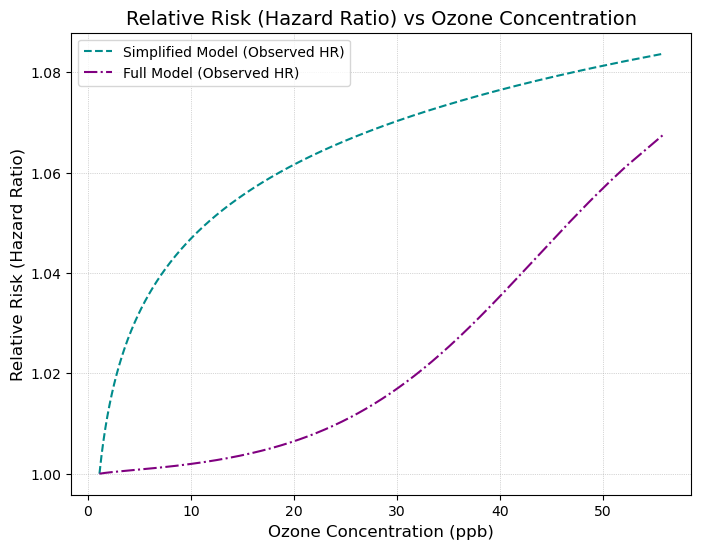

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import matplotlib.gridspec as gridspec
from pylab import *
from matplotlib.colors import LinearSegmentedColormap
import pdb
import re

def calculate_hr(C, theta, mu=None, nu=None, simplified=False):
    a = np.min(C)
    z = C - a
    T_z = np.log(z + 1)

    if simplified:
        return np.exp(theta * T_z)
    else:
        w_z = 1 / (1 + np.exp(-(z - mu)/nu))
        return np.exp(theta * T_z * w_z)

def fit_simplified_model(C, hr_observed):
    a = np.min(C)
    z = C - a
    T_z = np.log(z + 1)
    log_hr = np.log(hr_observed)

    model = LinearRegression(fit_intercept=False)
    model.fit(T_z.reshape(-1, 1), log_hr)
    return model.coef_[0]

def fit_full_model(C, hr_observed, initial_guess=[1.0, 0.0, 1.0]):
    a = np.min(C)
    z = C - a

    def model_function(z, theta, mu, nu):
        T_z = np.log(z + 1)
        w_z = 1 / (1 + np.exp(-(z - mu)/nu))
        return np.exp(theta * T_z * w_z)

    params_opt, _ = curve_fit(model_function, z, hr_observed, p0=initial_guess)
    return tuple(params_opt)

if __name__ == "__main__":
    # Cargar datos desde un archivo CSV
    filename = "data_insumo/Ozono_llenado.csv"  # Reemplaza con el nombre de tu archivo
    df = pd.read_csv(filename)

    # Asumimos que la columna con los valores de ozono se llama 'Ozone'
    C = df["Ozone"].values

    # Asegurar que los datos están en orden y sin valores nulos
    C = np.sort(C[~np.isnan(C)])

    # Calcular HR usando un modelo simplificado
    theta_true = 0.02
    hr_simple = calculate_hr(C, theta_true, simplified=True)
    theta_est = fit_simplified_model(C, hr_simple)

    print(f"Simplified model: True theta = {theta_true:.4f}, Estimated theta = {theta_est:.4f}")

    # Calcular HR usando el modelo completo
    theta_true, mu_true, nu_true = 0.02, 40.0, 10.0
    hr_full = calculate_hr(C, theta_true, mu_true, nu_true)
    params_est = fit_full_model(C, hr_full)

    print(f"Full model: True params = ({theta_true}, {mu_true}, {nu_true})")
    print(f"            Estimated params = ({params_est[0]:.4f}, {params_est[1]:.4f}, {params_est[2]:.4f})")

    # Graficar los resultados
    plt.figure(figsize=(8, 6))
    plt.plot(C, hr_simple, label="Simplified Model (Observed HR)", color="darkcyan", linestyle="--")
    plt.plot(C, hr_full, label="Full Model (Observed HR)", color="purple", linestyle="-.")

    plt.title("Relative Risk (Hazard Ratio) vs Ozone Concentration", fontsize=14)
    plt.xlabel("Ozone Concentration (ppb)", fontsize=12)
    plt.ylabel("Relative Risk (Hazard Ratio)", fontsize=12)
    plt.legend()
    plt.grid(linestyle = ":", linewidth = 0.5)
    plt.show()


# GRAFICAS DATOS DEMOGRAFIA

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd

In [4]:
data_mort = pd.read_excel('data_insumo/osb_demografia-causasmortalidad_1.xlsx')
data_poblacional = pd.read_excel('data_insumo/osb_demografia-poblacion-localidad.xlsx')

In [5]:
codigos_filtrar = ['I255', 'J449', 'J440', 'J441', 'I679', 'D022', 'J22X', 'J987', 'J448']

In [6]:
datos_filtrados = data_mort[data_mort['MORTALIDAD_CODIGO_CIE10'].isin(codigos_filtrar)]

In [7]:
datos_2017 = datos_filtrados[datos_filtrados['ANIO'] == 2017]

In [8]:
tabla_resumen = pd.pivot_table(data=datos_2017,
                               index=['MORTALIDAD_CODIGO_CIE10'],
                               columns=['SEXO', 'LOCALIDAD_NOMBRE'],
                               aggfunc='size',
                               fill_value=0)

nombre_archivo = "tabla_resumen_2017.xlsx"
tabla_resumen.to_excel(nombre_archivo)


In [9]:
datos_filtrados = data_mort[data_mort['MORTALIDAD_CODIGO_CIE10'].isin(codigos_filtrar)].copy()

# Renombrar los códigos de mortalidad con su descripción
descripcion_codigos = {
    'I255': 'CARDIOMIOPATIA ISQUEMICA',
    'J449': 'ENFERMEDAD PULMONAR OBSTRUCTIVA CRONICA, NO ESPECIFICADA',
    'J440': 'ENFERMEDAD PULMONAR OBSTRUCTIVA CRONICA CON INFECCION AGUDA DE LAS VIAS RESPIRATORIAS INFERIORES',
    'J441': 'ENFERMEDAD PULMONAR OBSTRUCTIVA CRONICA CON EXACERBACION AGUDA, NO ESPECIFICADA',
    'I679': 'ENFERMEDAD CEREBROVASCULAR, NO ESPECIFICADA',
    'D022': 'CARCINOMA IN SITU DEL BRONQUIO Y DEL PULMON',
    'J22X': 'INFECCION AGUDA NO ESPECIFICADA DE LAS VIAS RESPIRATORIAS INFERIORES',
    'J987': 'Infecciones respiratorias, clasificadas en otra parte',
    'J448': 'OTRAS ENFERMEDADES PULMONARES OBSTRUCTIVAS CRONICAS ESPECIFICADAS'
}

datos_filtrados['MORTALIDAD_DESCRIPCION'] = datos_filtrados['MORTALIDAD_CODIGO_CIE10'].map(descripcion_codigos)


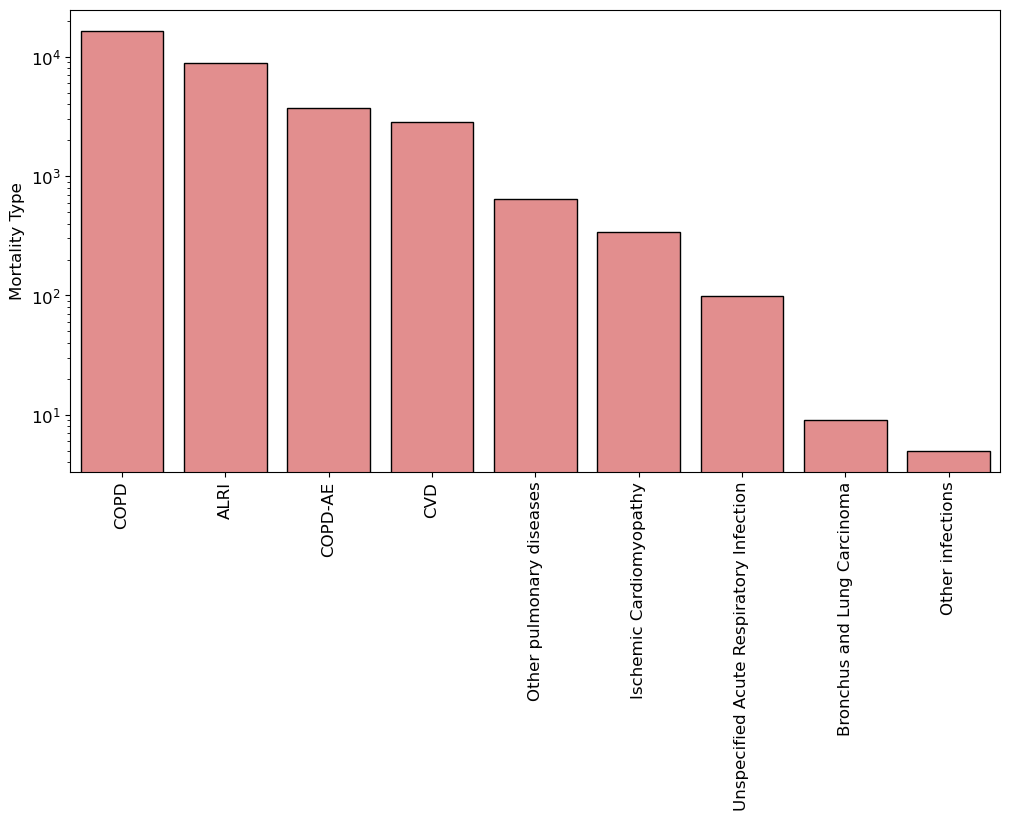

In [10]:
sns.color_palette("rocket")

# Custom labels for x-ticks 
custom_labels = ['COPD', 'ALRI', 'COPD-AE', 'CVD', 'Other pulmonary diseases', 'Ischemic Cardiomyopathy', 
                 'Unspecified Acute Respiratory Infection', 'Bronchus and Lung Carcinoma', 'Other infections']

# Graficar distribución por causa de mortalidad
plt.figure(figsize=(12, 6))
sns.countplot(data=datos_filtrados, x='MORTALIDAD_DESCRIPCION', 
              order=datos_filtrados['MORTALIDAD_DESCRIPCION'].value_counts().index, 
              color = 'lightcoral', edgecolor = 'k')
plt.xlabel(None)
#plt.xticks(rotation=90)
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=90, fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Mortality Type', fontsize = 12)
plt.yscale('log')
plt.show()

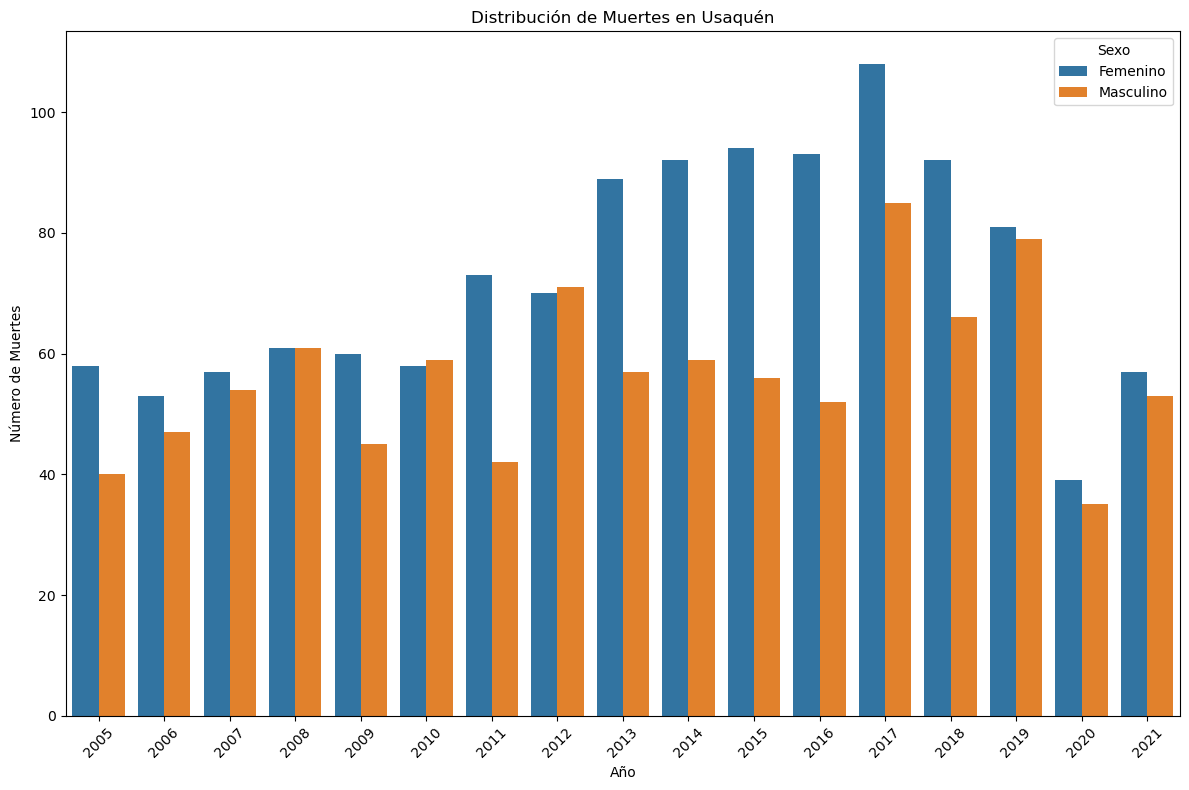

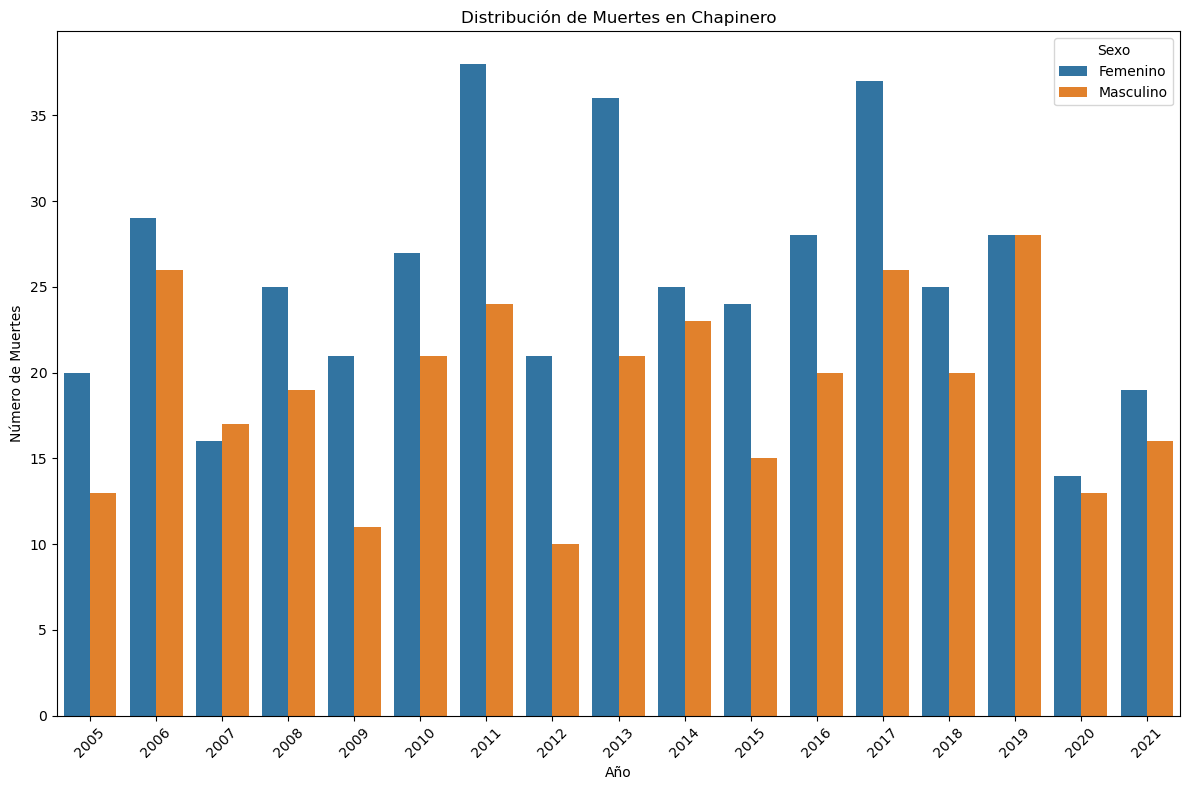

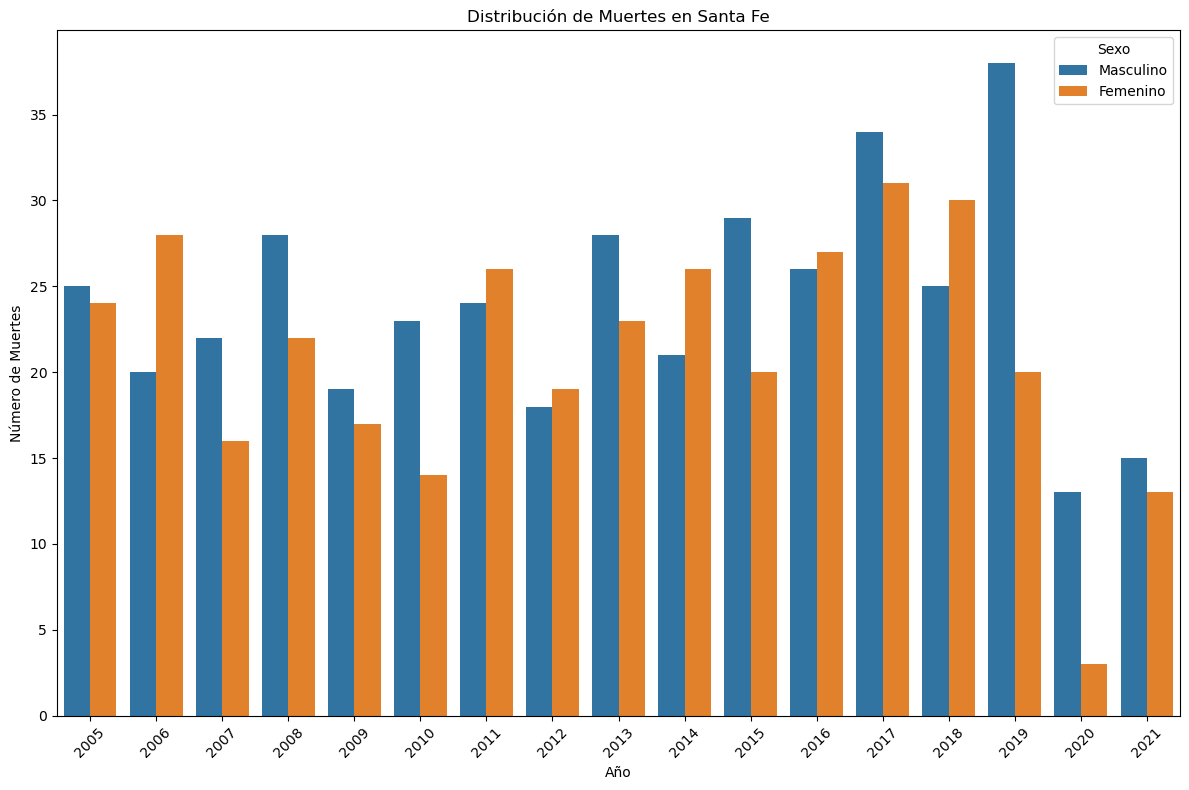

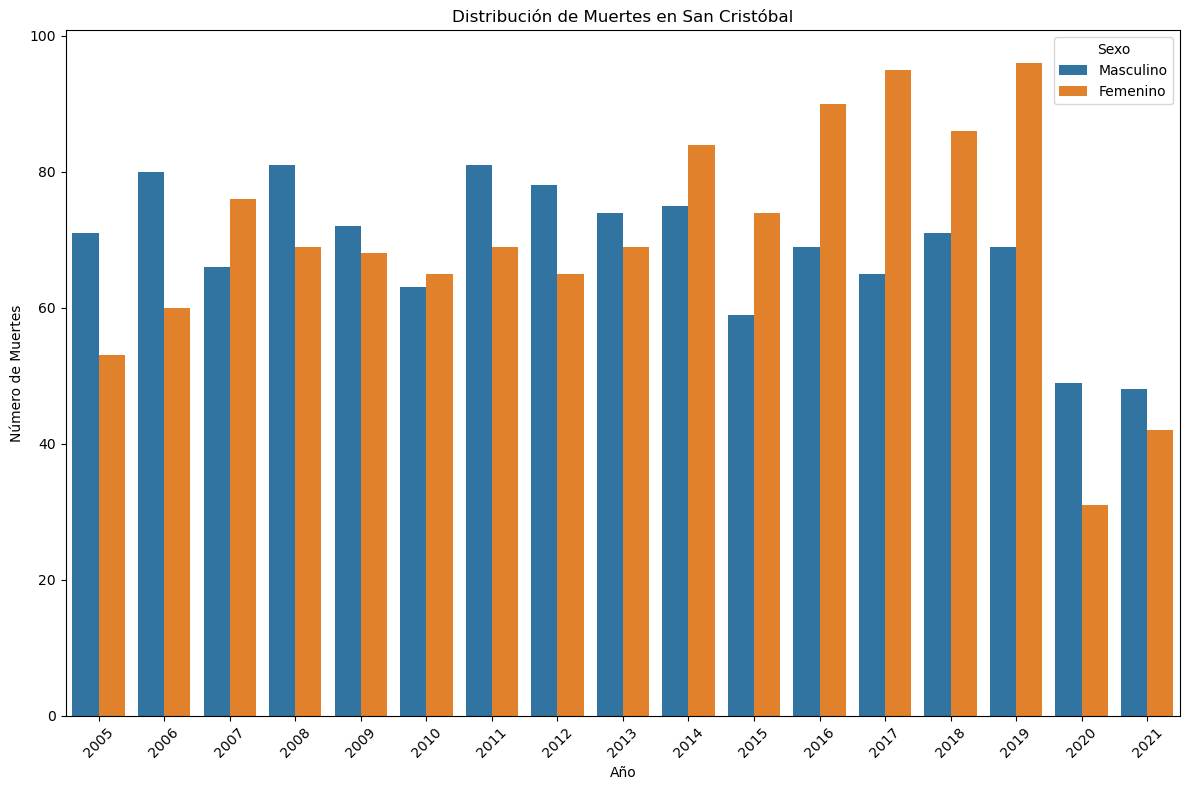

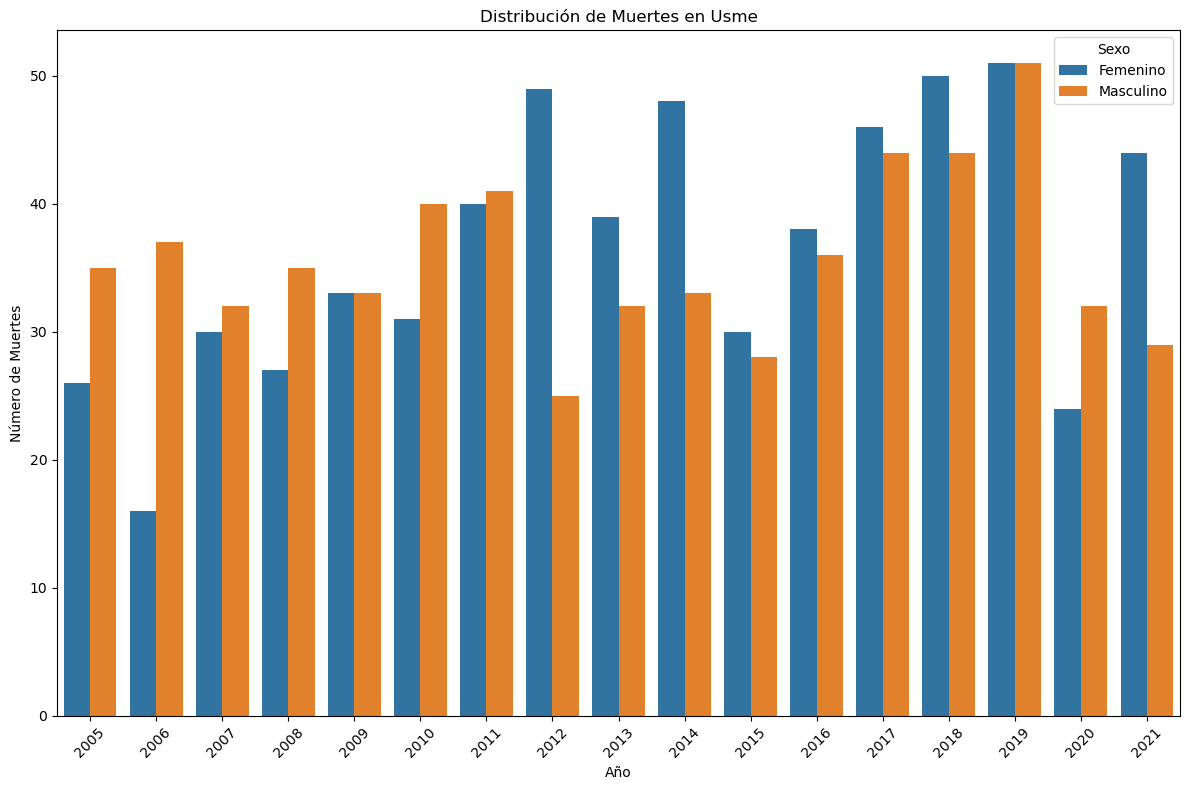

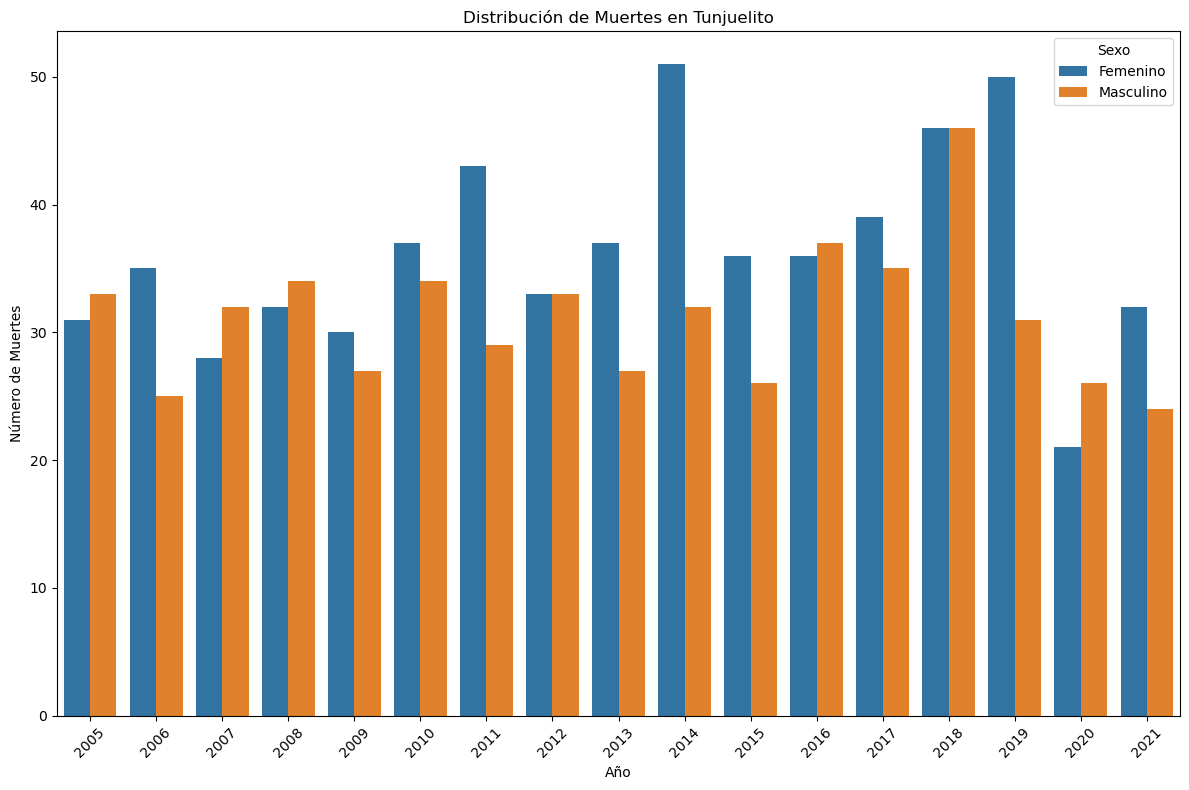

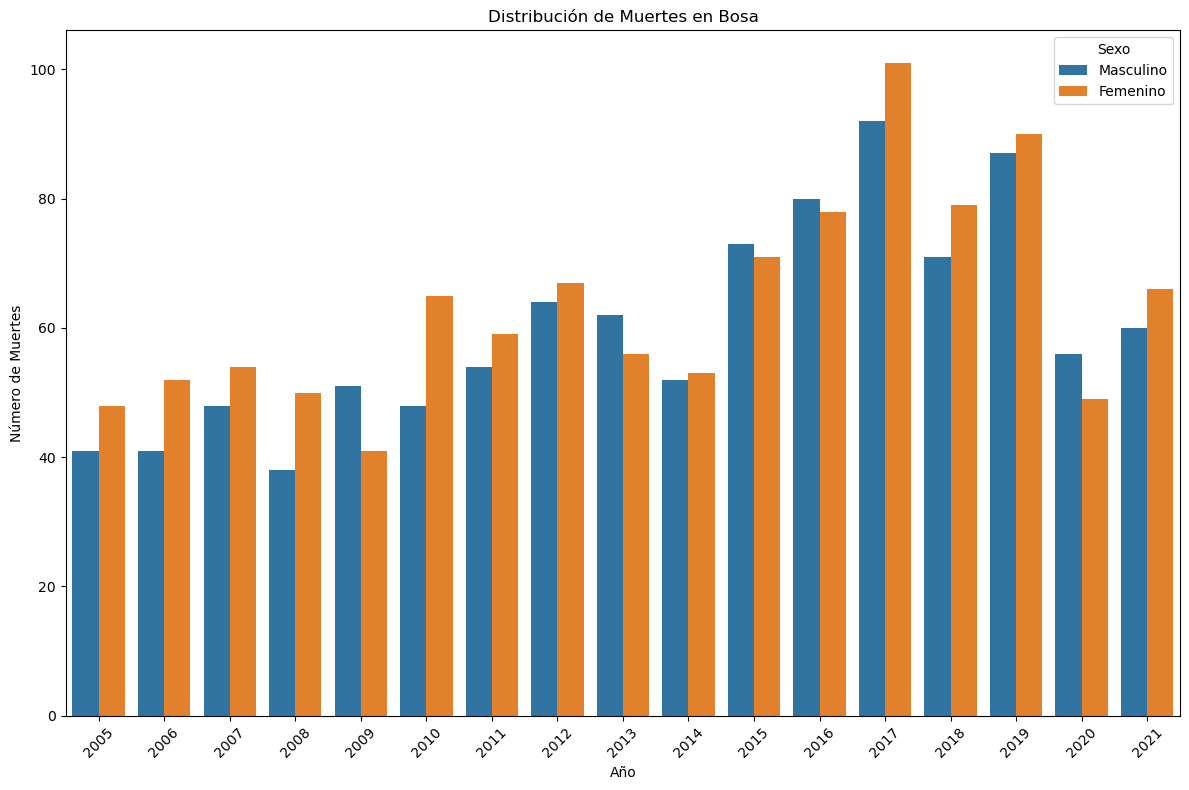

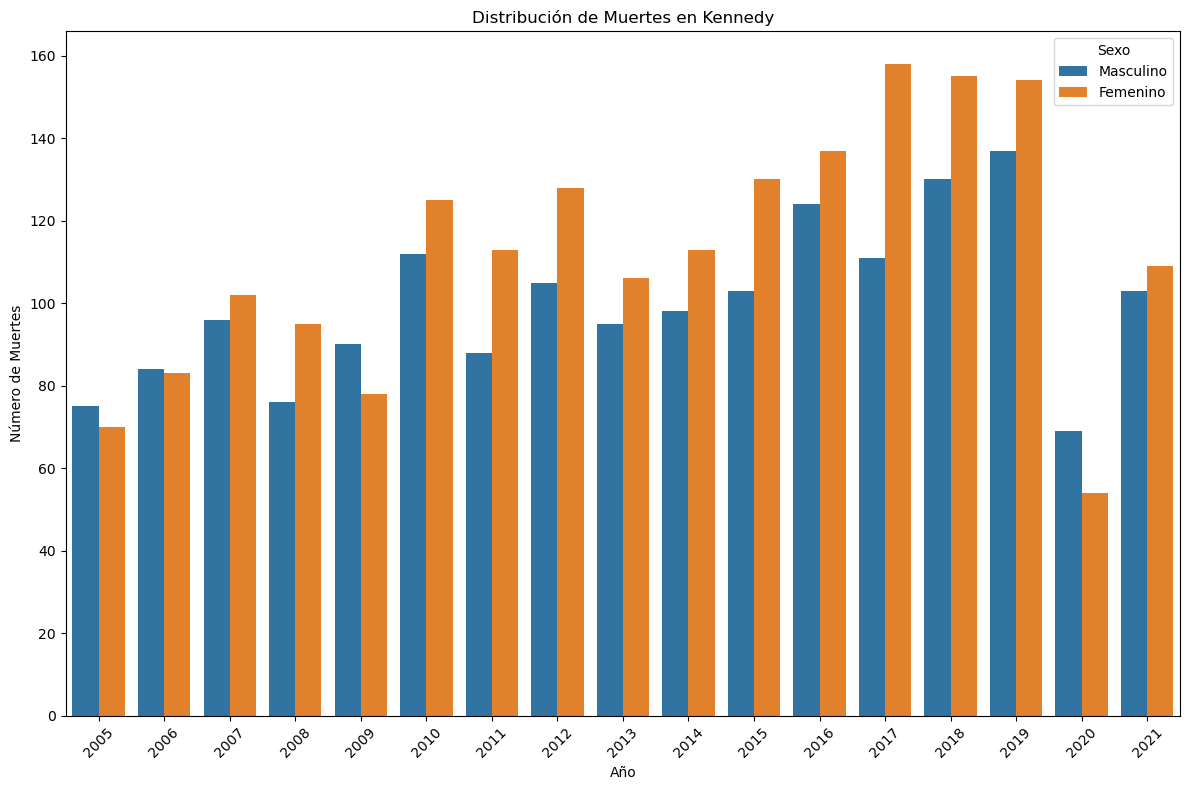

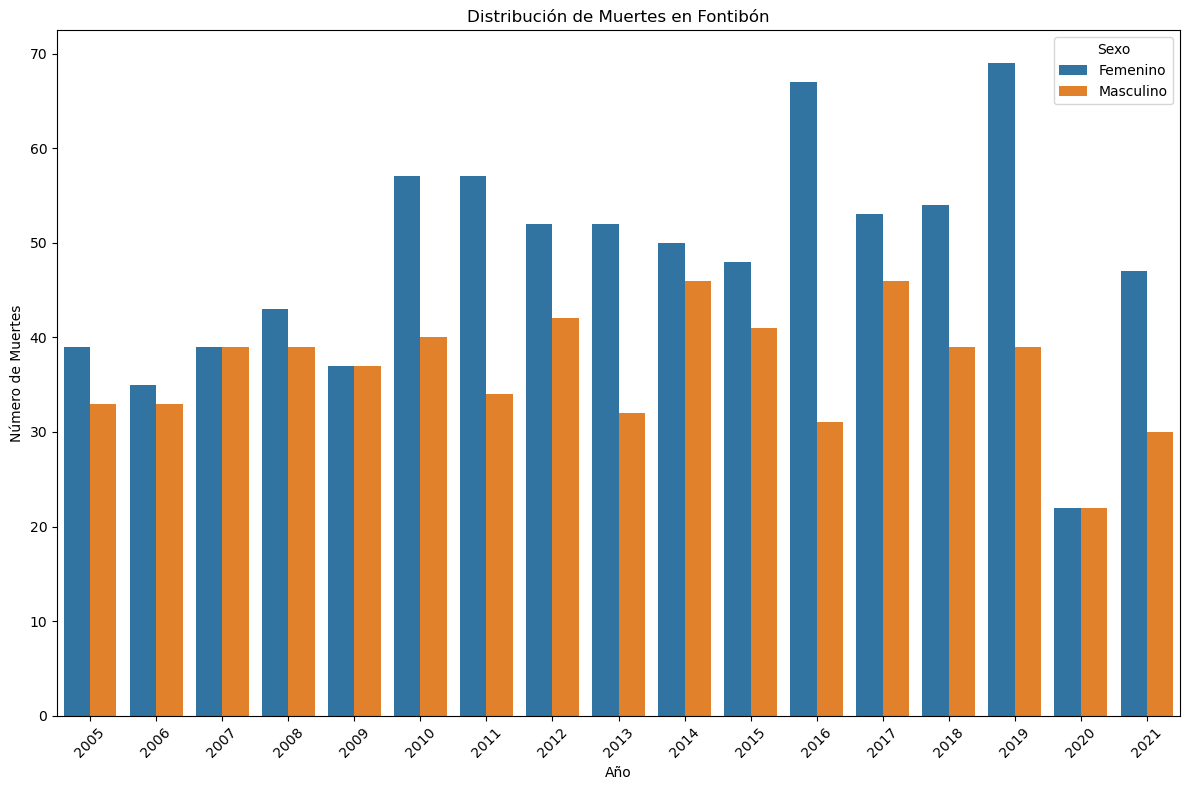

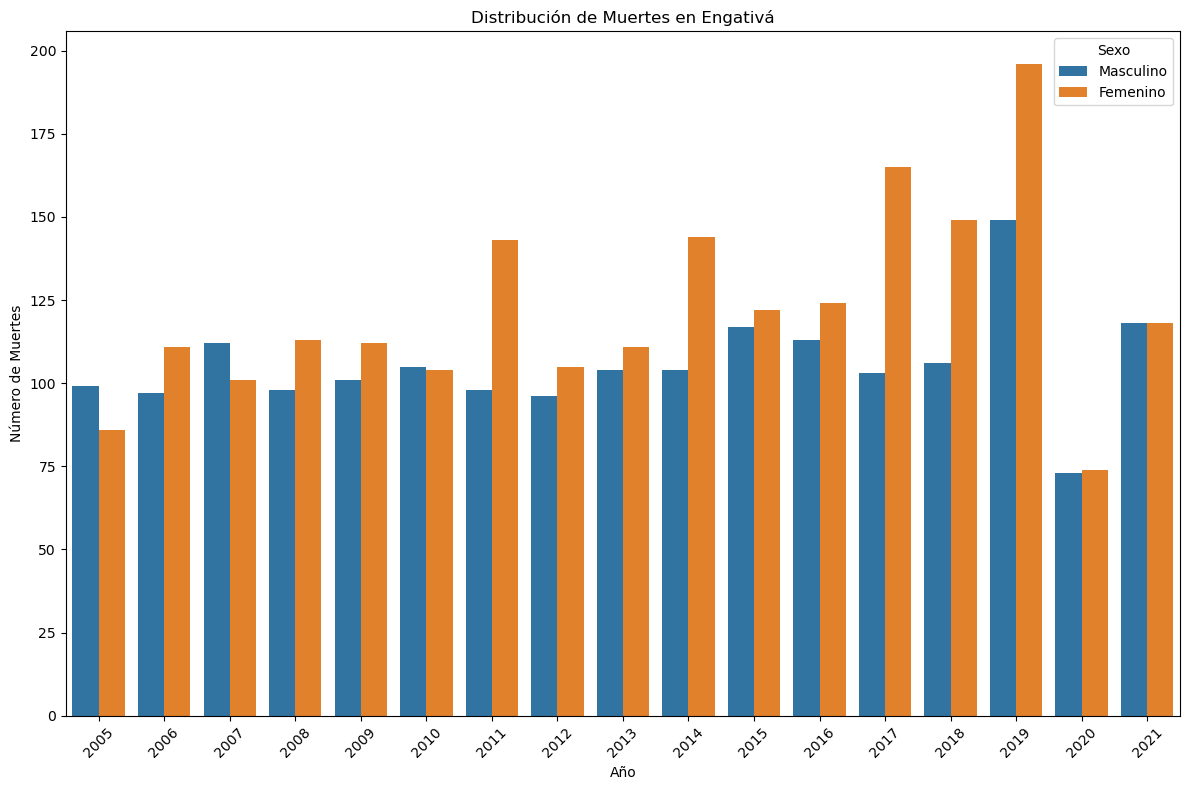

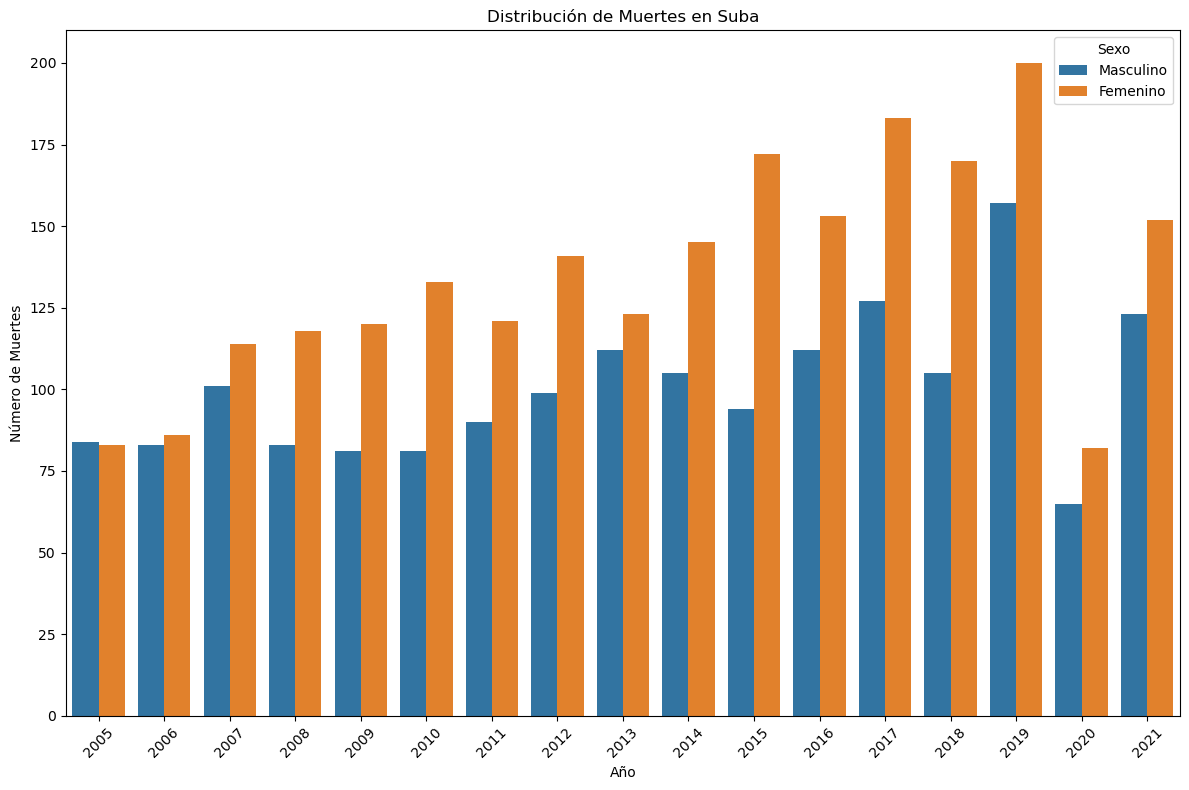

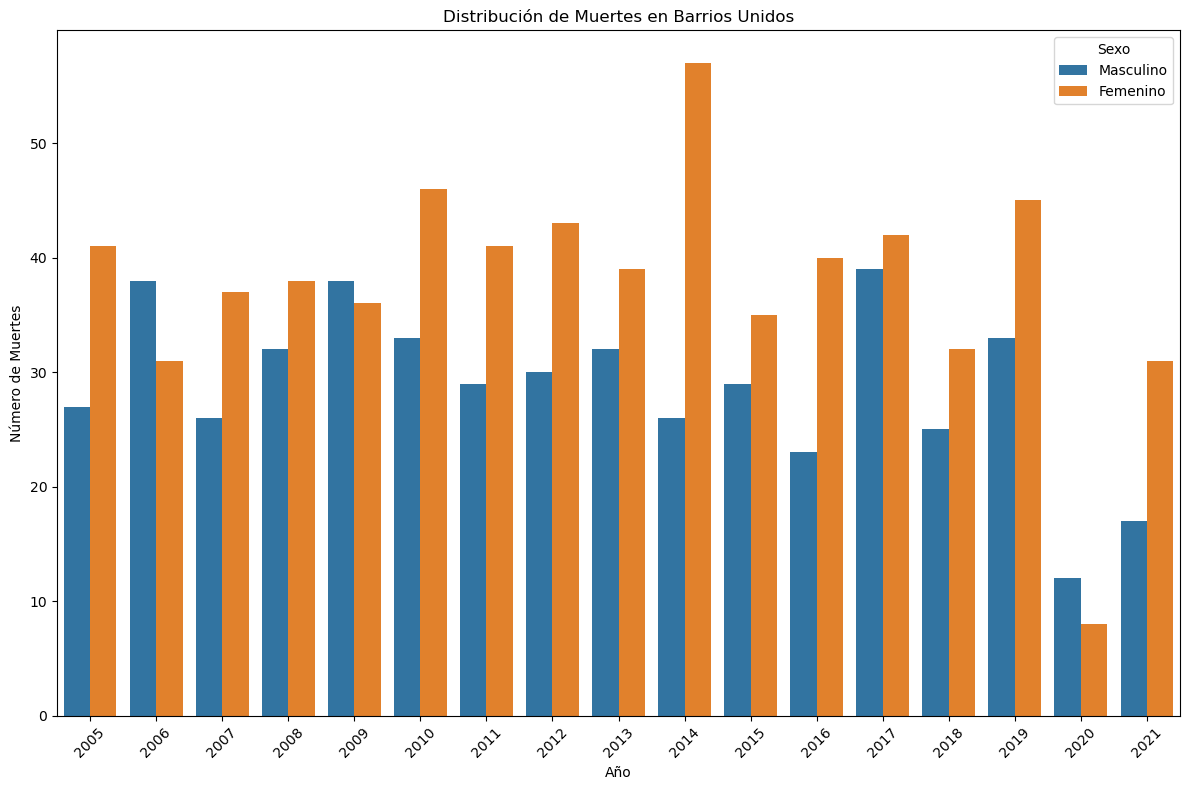

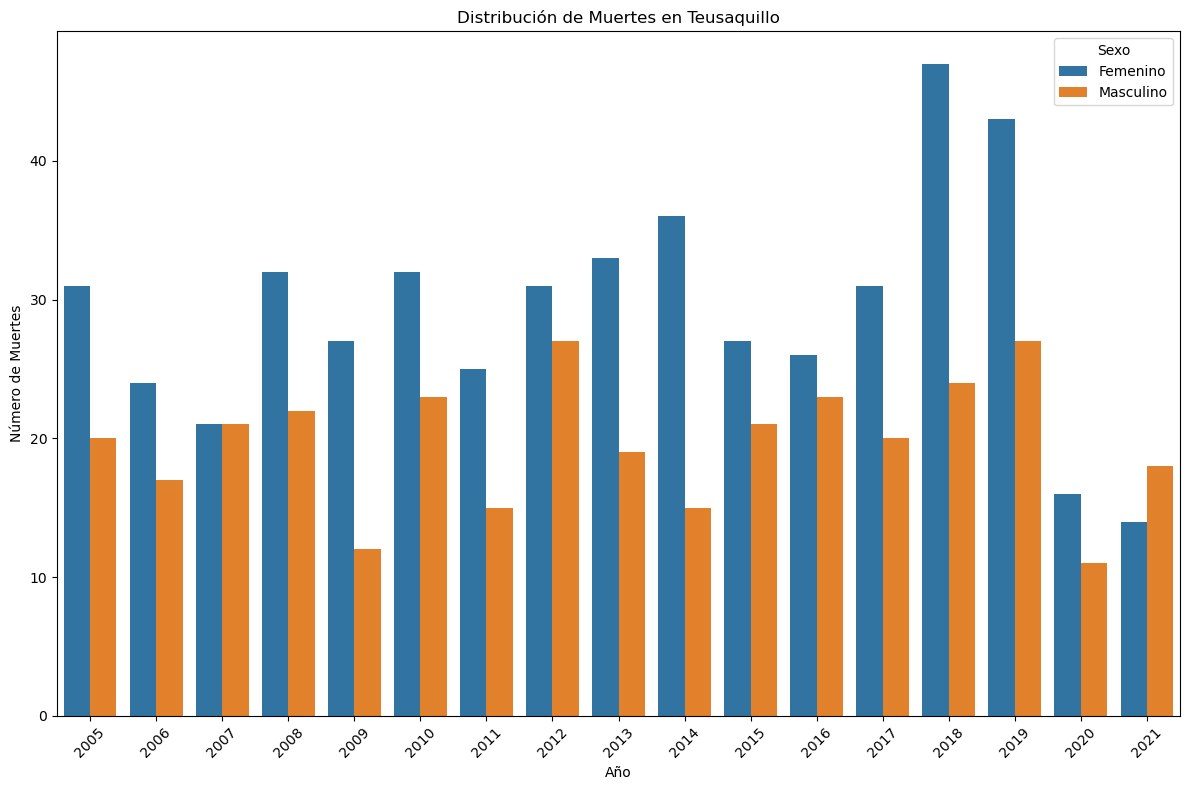

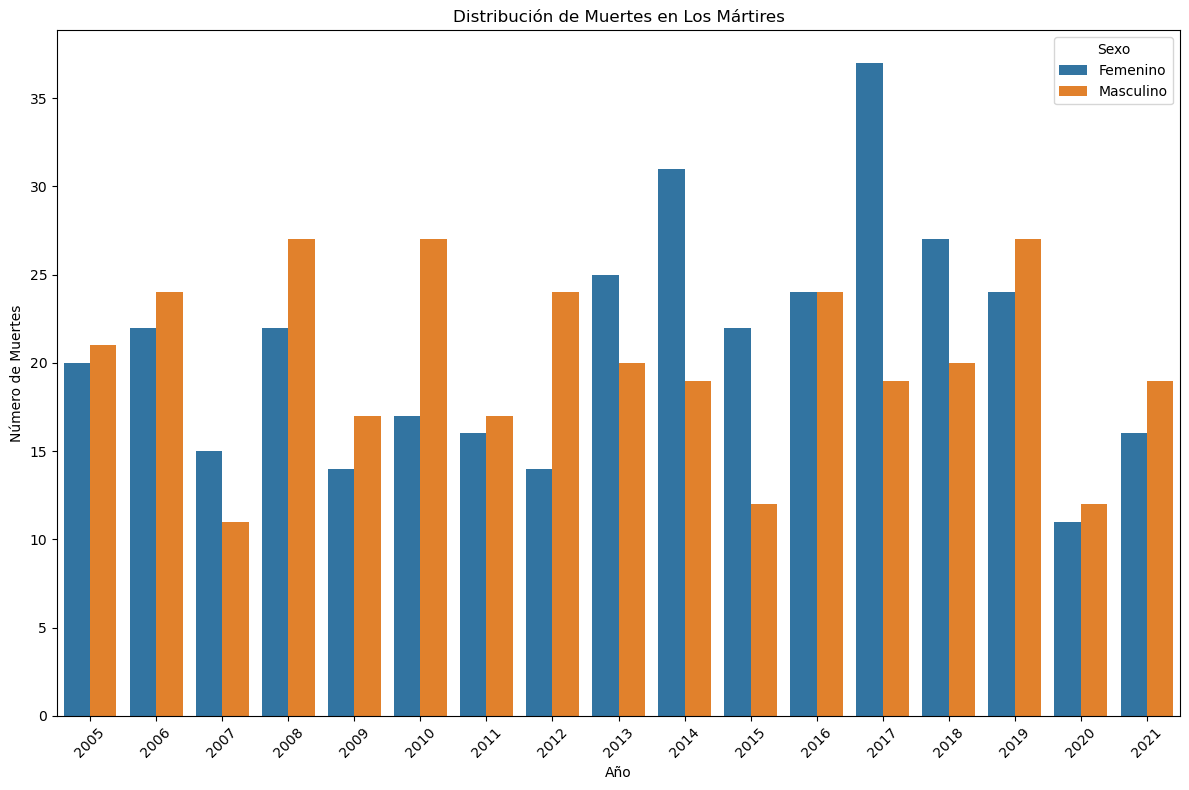

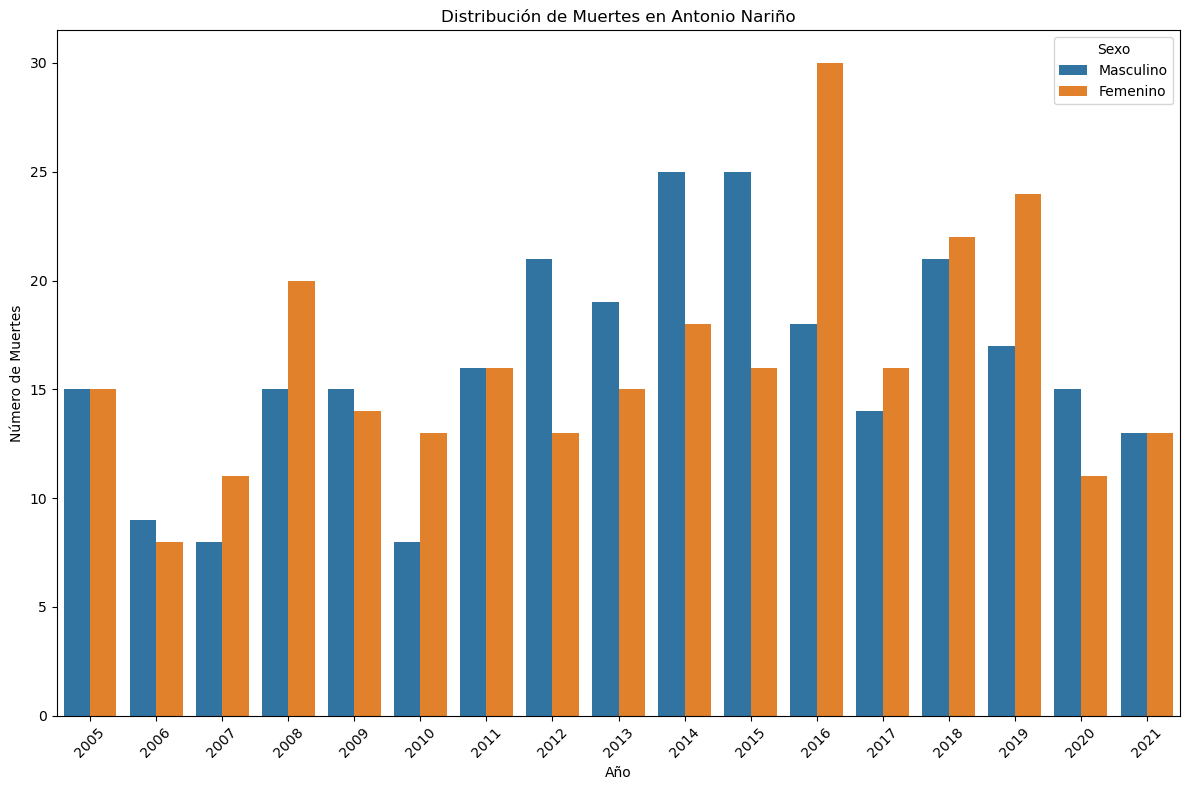

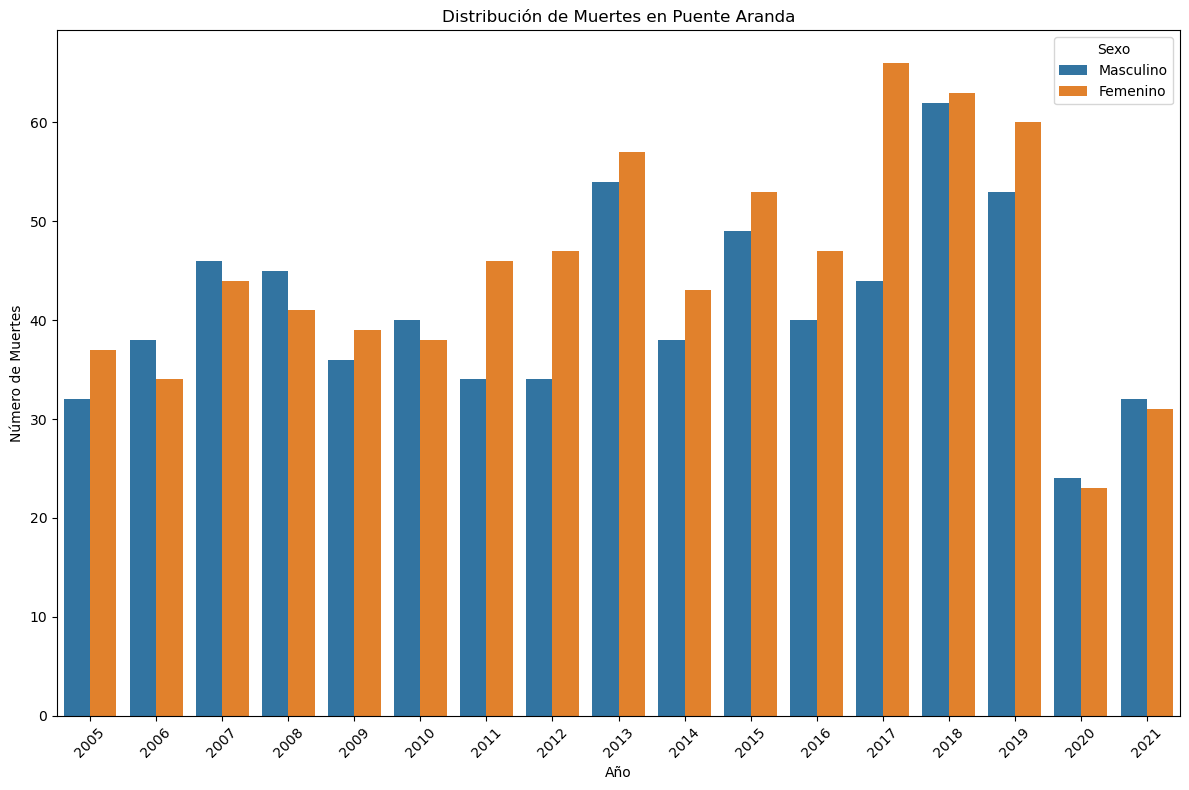

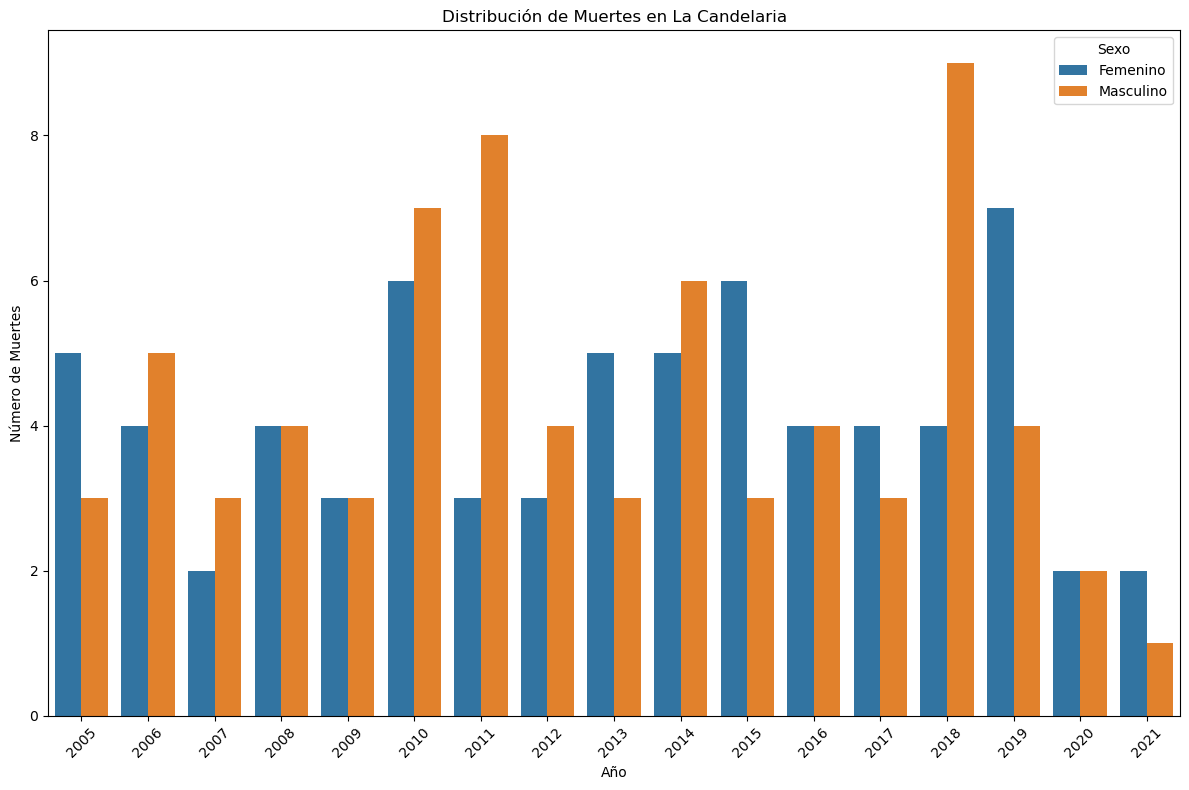

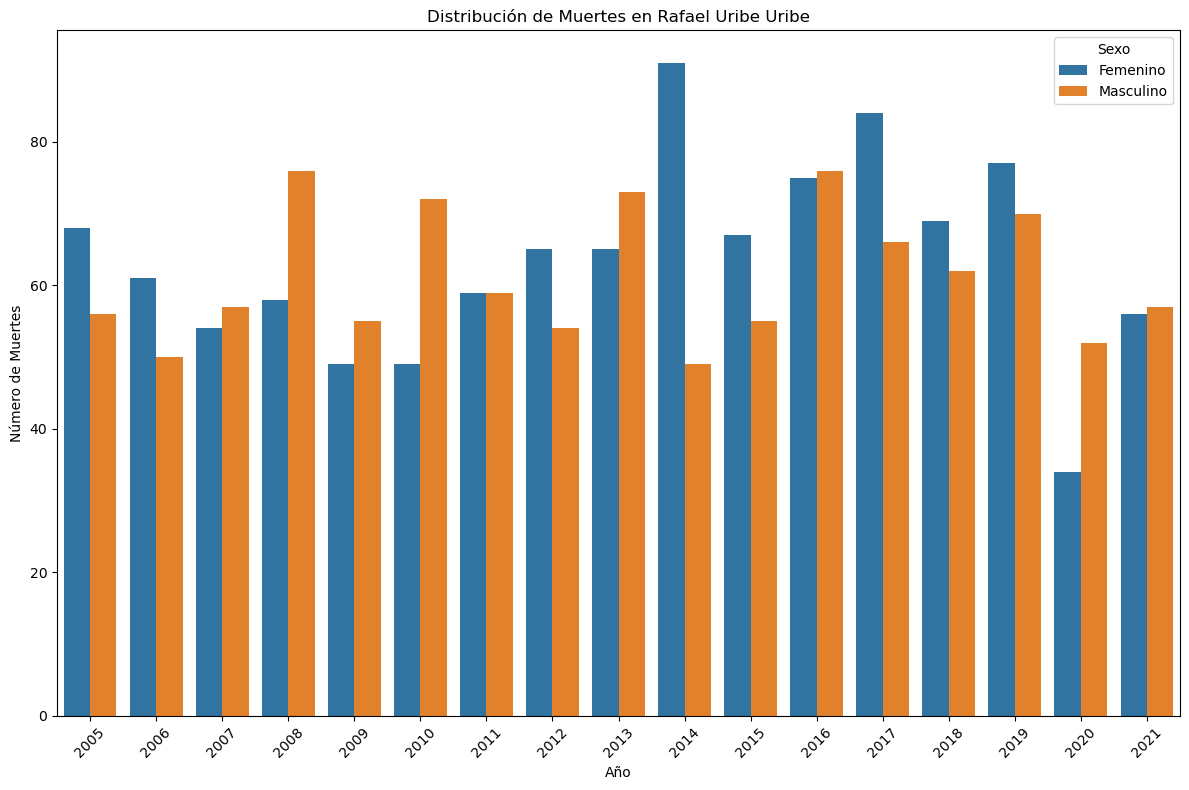

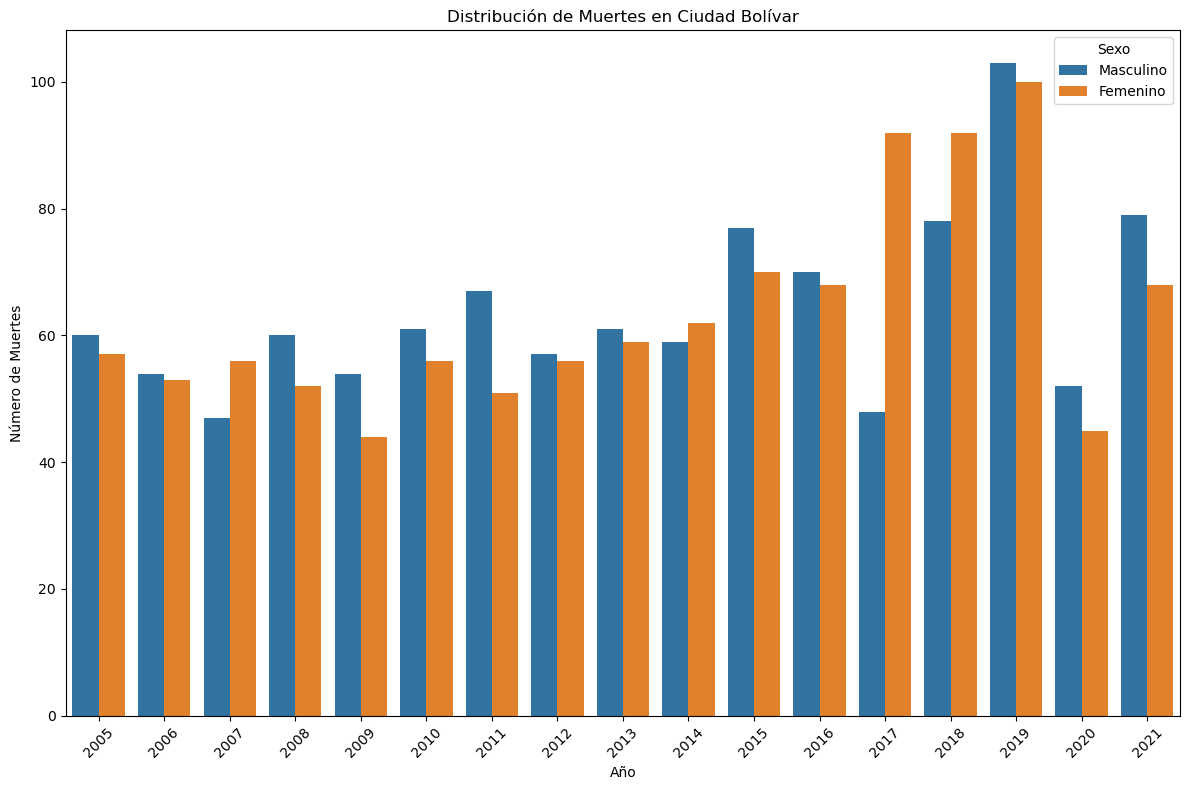

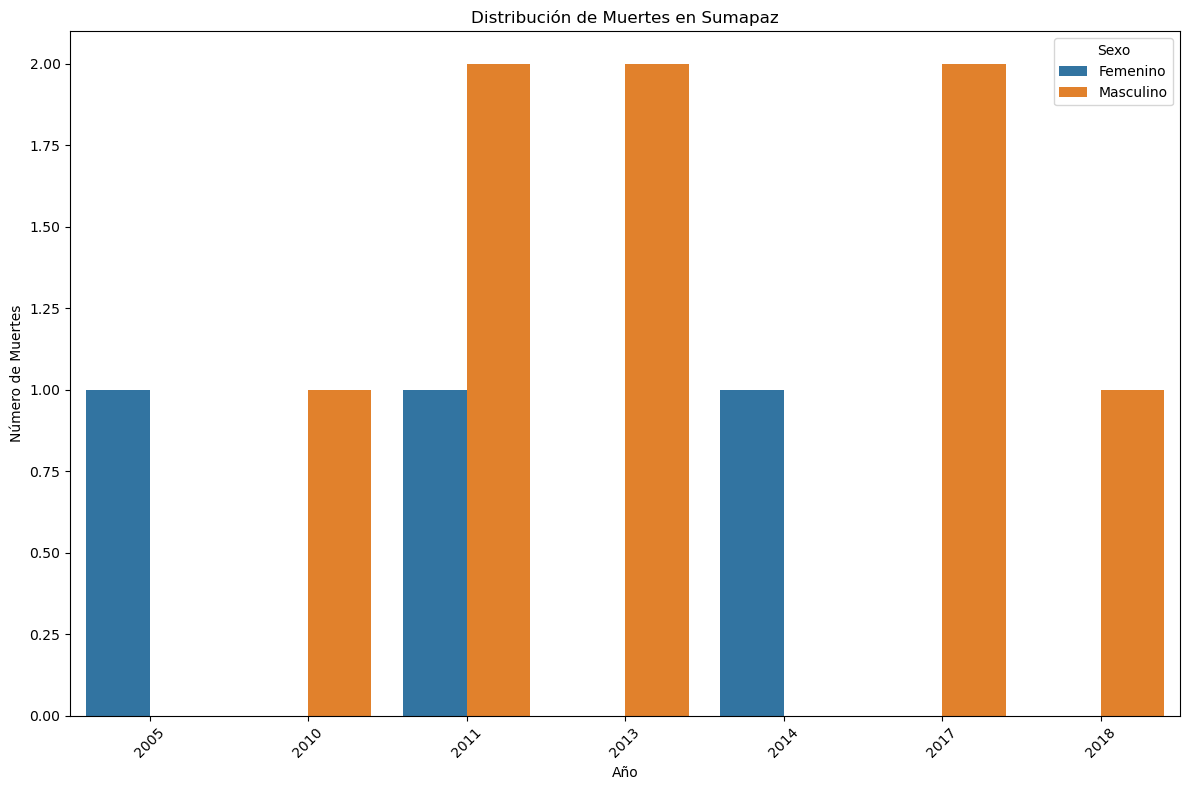

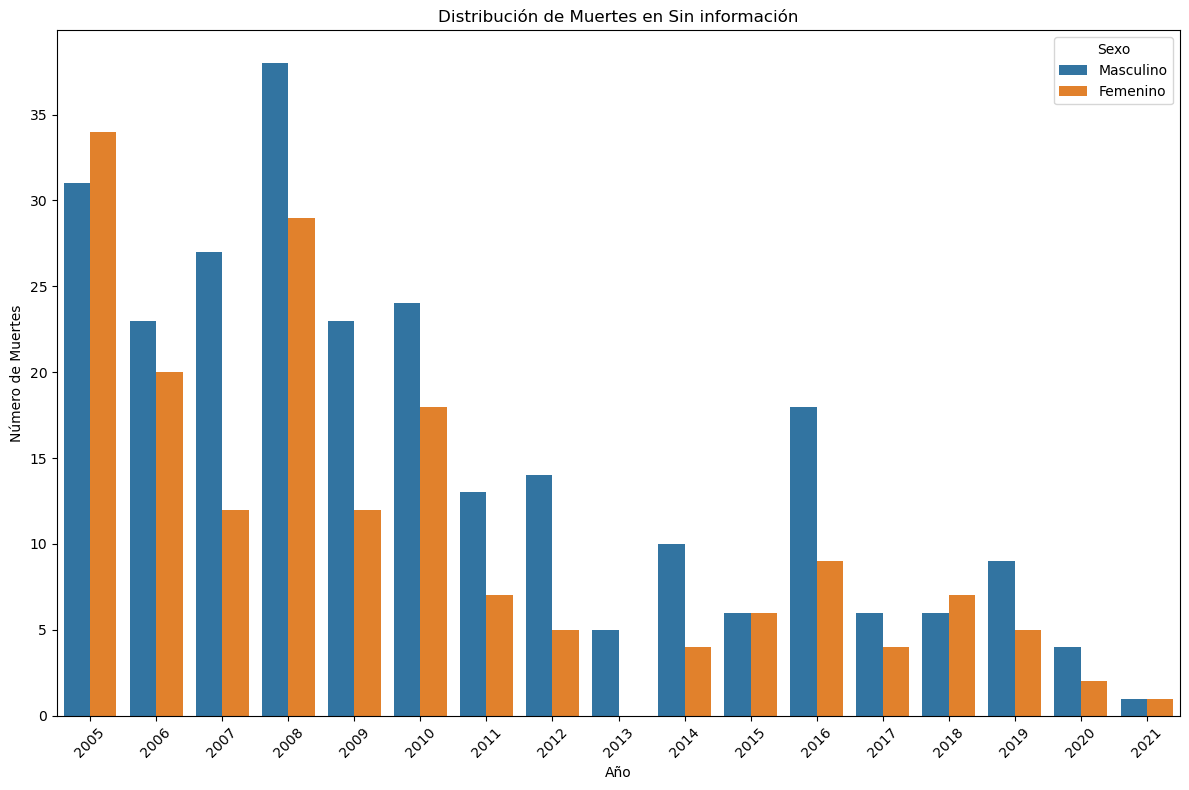

In [11]:
# Obtener una lista de localidades únicas
localidades_unicas = datos_filtrados['LOCALIDAD_NOMBRE'].unique()

for localidad in localidades_unicas:
    datos_localidad = datos_filtrados[datos_filtrados['LOCALIDAD_NOMBRE'] == localidad]

    plt.figure(figsize=(12, 8))
    sns.countplot(data=datos_localidad, x='ANIO', hue='SEXO',
                  dodge=True)
    plt.title(f'Distribución de Muertes en {localidad}')
    plt.xlabel('Año')
    plt.ylabel('Número de Muertes')
    plt.legend(title='Sexo')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

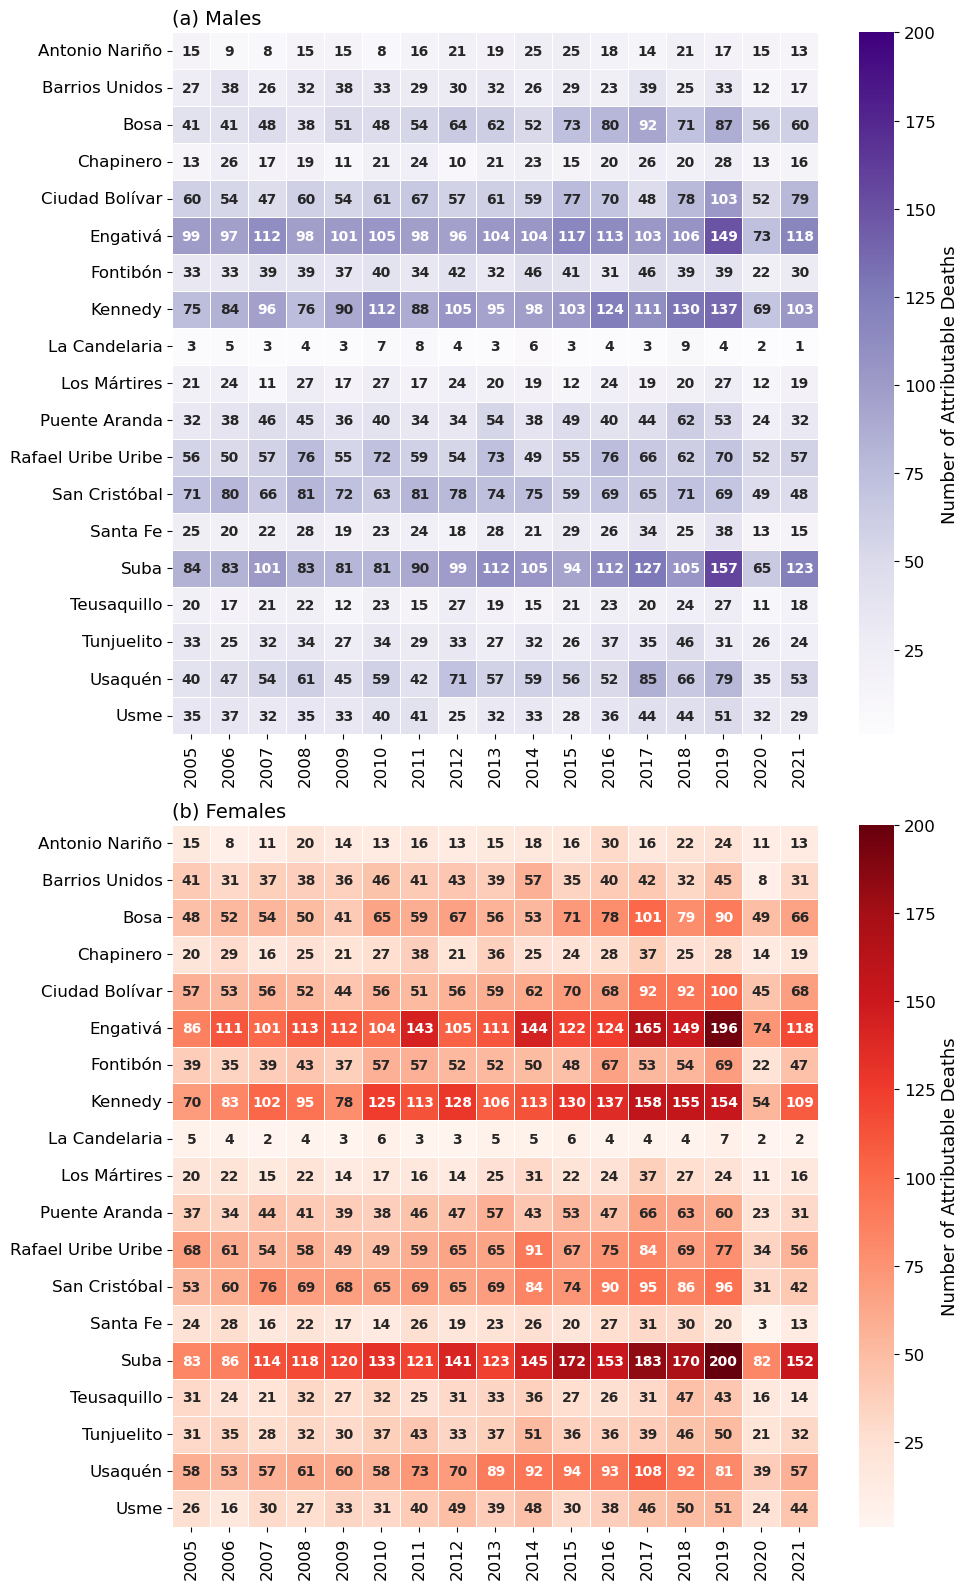

In [12]:
# Pivot data to create a heatmap-compatible format
heatmap_data_male = datos_filtrados[datos_filtrados['SEXO'] == 'Masculino'].pivot_table(
    index='LOCALIDAD_NOMBRE', columns='ANIO', values='SEXO', aggfunc='count'
)

heatmap_data_female = datos_filtrados[datos_filtrados['SEXO'] == 'Femenino'].pivot_table(
    index='LOCALIDAD_NOMBRE', columns='ANIO', values='SEXO', aggfunc='count'
)

# Remove "Sin información" row from both datasets
heatmap_data_male = heatmap_data_male.drop(index="Sin información", errors="ignore")
heatmap_data_female = heatmap_data_female.drop(index="Sin información", errors="ignore")
heatmap_data_male = heatmap_data_male.drop(index="Sumapaz", errors="ignore")
heatmap_data_female = heatmap_data_female.drop(index="Sumapaz", errors="ignore")

# Get global min/max for consistent color scale
vmin = min(heatmap_data_male.min().min(), heatmap_data_female.min().min())
vmax = max(heatmap_data_male.max().max(), heatmap_data_female.max().max())

# Create figure with GridSpec
fig = plt.figure(figsize=(10, 16))
gs = gridspec.GridSpec(2, 1)

# First subplot: Male Deaths
ax1 = fig.add_subplot(gs[0])
sns.heatmap(
    heatmap_data_male, cmap="Purples", annot=True, fmt=".0f", linewidths=0.5, 
    edgecolor="black", annot_kws={"size": 10, "weight": "bold"}, mask=heatmap_data_male.isnull(),
    yticklabels=1, xticklabels=1, square=False, ax=ax1, vmin=vmin, vmax=vmax
)
ax1.set_title("(a) Males", loc="left", fontsize=14)
plt.xticks(rotation = 90)
ax1.set_ylabel("", fontsize=12)
ax1.tick_params(axis="both", labelsize=12)  # Set tick fontsize

# Colorbar for male deaths
cbar1 = ax1.collections[0].colorbar
cbar1.set_label("Number of Attributable Deaths", fontsize=13)
cbar1.ax.tick_params(labelsize=12)  # Set colorbar tick fontsize
plt.xlabel("")

# Second subplot: Female Deaths
ax2 = fig.add_subplot(gs[1])
sns.heatmap(
    heatmap_data_female, cmap="Reds", annot=True, fmt=".0f", linewidths=0.5, 
    edgecolor="black", annot_kws={"size": 10, "weight": "bold"}, mask=heatmap_data_female.isnull(),
    yticklabels=1, xticklabels=1, square=False, ax=ax2, vmin=vmin, vmax=vmax
)
ax2.set_title("(b) Females", loc="left", fontsize=14)
plt.xticks(rotation = 90)
ax2.set_ylabel("")  # Remove duplicate ylabel
ax2.tick_params(axis="both", labelsize=12)  # Set tick fontsize

# Colorbar for female deaths
cbar2 = ax2.collections[0].colorbar
cbar2.set_label("Number of Attributable Deaths", fontsize=13)
cbar2.ax.tick_params(labelsize=12)  # Set colorbar tick fontsize
plt.xlabel("")

# Adjust layout
plt.tight_layout()
plt.show()

In [13]:
# NORMALIZACION DE DATOS: 100.000
data_poblacional = data_poblacional.rename(columns={
    'Año': 'ANIO',
    'Localidad': 'LOCALIDAD_NOMBRE'
})

# Agrupar muertes por sexo, localidad y año
conteo_m = datos_filtrados[datos_filtrados['SEXO'] == 'Masculino'] \
    .groupby(['LOCALIDAD_NOMBRE', 'ANIO']).size().reset_index(name='MUERTES')

conteo_f = datos_filtrados[datos_filtrados['SEXO'] == 'Femenino'] \
    .groupby(['LOCALIDAD_NOMBRE', 'ANIO']).size().reset_index(name='MUERTES')

# Filtrar población por sexo
tmp_h = data_poblacional[data_poblacional['Sexo'] == 'Hombres']
poblacion_hombres = tmp_h.groupby(['ANIO', 'Cod_Loc', 'LOCALIDAD_NOMBRE'])['Población'].sum().reset_index()

tmp_m = data_poblacional[data_poblacional['Sexo'] == 'Mujeres']
poblacion_mujeres = tmp_m.groupby(['ANIO', 'Cod_Loc', 'LOCALIDAD_NOMBRE'])['Población'].sum().reset_index()

# Merge de muertes con población
merged_m = pd.merge(conteo_m, poblacion_hombres, on=['LOCALIDAD_NOMBRE', 'ANIO'], how='left')
merged_f = pd.merge(conteo_f, poblacion_mujeres, on=['LOCALIDAD_NOMBRE', 'ANIO'], how='left')

# Calcular tasa por 100,000 habitantes
merged_m['TASA'] = (merged_m['MUERTES'] / merged_m['Población']) * 100000
merged_f['TASA'] = (merged_f['MUERTES'] / merged_f['Población']) * 100000

# Añadir columna sexo para luego unir todo
merged_m['SEXO'] = 'Masculino'
merged_f['SEXO'] = 'Femenino'

# Unir ambos DataFrames
merged_all = pd.concat([merged_m, merged_f], ignore_index=True)

# Mostrar resultados
print(merged_all.head())


  LOCALIDAD_NOMBRE  ANIO  MUERTES  Cod_Loc  Población       TASA       SEXO
0   Antonio Nariño  2005       15     15.0    55115.0  27.215821  Masculino
1   Antonio Nariño  2006        9     15.0    51869.0  17.351404  Masculino
2   Antonio Nariño  2007        8     15.0    49166.0  16.271407  Masculino
3   Antonio Nariño  2008       15     15.0    46911.0  31.975443  Masculino
4   Antonio Nariño  2009       15     15.0    45036.0  33.306688  Masculino


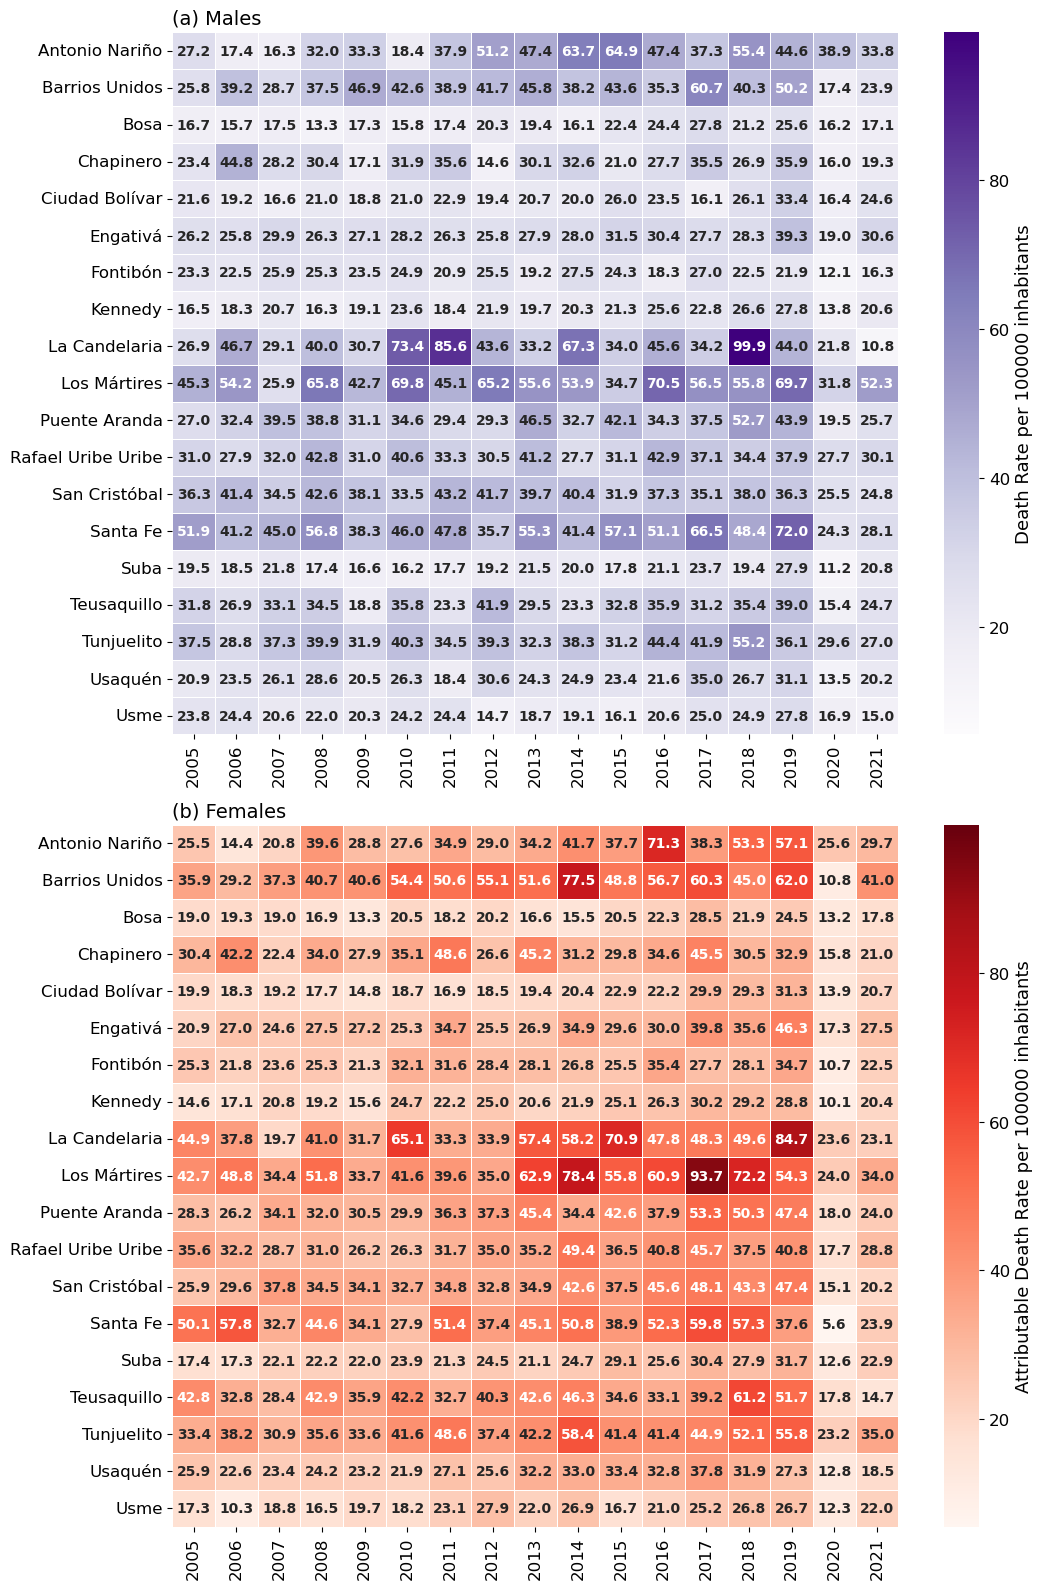

In [14]:
#FILTRO POR GRUPO DE EDAD SUMARLOS

# Crear pivot tables para tasas, separadas por sexo
heatmap_data_male = merged_all[merged_all['SEXO'] == 'Masculino'].pivot_table(
    index='LOCALIDAD_NOMBRE', columns='ANIO', values='TASA'
)

heatmap_data_female = merged_all[merged_all['SEXO'] == 'Femenino'].pivot_table(
    index='LOCALIDAD_NOMBRE', columns='ANIO', values='TASA'
)

# Quitar localidades no deseadas
heatmap_data_male = heatmap_data_male.drop(index=["Sin información", "Sumapaz"], errors="ignore")
heatmap_data_female = heatmap_data_female.drop(index=["Sin información", "Sumapaz"], errors="ignore")

# Escala de color consistente entre ambos heatmaps
vmin = min(heatmap_data_male.min().min(), heatmap_data_female.min().min())
vmax = max(heatmap_data_male.max().max(), heatmap_data_female.max().max())

# Crear figura y layout
fig = plt.figure(figsize=(11, 16))
gs = gridspec.GridSpec(2, 1)

# Heatmap para hombres (tasas)
ax1 = fig.add_subplot(gs[0])
sns.heatmap(
    heatmap_data_male, cmap="Purples", annot=True, fmt=".1f", linewidths=0.5,
    edgecolor="black", annot_kws={"size": 10, "weight": "bold"}, mask=heatmap_data_male.isnull(),
    yticklabels=1, xticklabels=1, square=False, ax=ax1, vmin=vmin, vmax=vmax
)
ax1.set_title("(a) Males", loc="left", fontsize=14)
plt.xticks(rotation=90)
ax1.set_ylabel("", fontsize=12)
ax1.tick_params(axis="both", labelsize=12)

cbar1 = ax1.collections[0].colorbar
cbar1.set_label("Death Rate per 100000 inhabitants", fontsize=13)
cbar1.ax.tick_params(labelsize=12)
plt.xlabel("")

# Heatmap para mujeres (tasas)
ax2 = fig.add_subplot(gs[1])
sns.heatmap(
    heatmap_data_female, cmap="Reds", annot=True, fmt=".1f", linewidths=0.5,
    edgecolor="black", annot_kws={"size": 10, "weight": "bold"}, mask=heatmap_data_female.isnull(),
    yticklabels=1, xticklabels=1, square=False, ax=ax2, vmin=vmin, vmax=vmax
)
ax2.set_title("(b) Females", loc="left", fontsize=14)
plt.xticks(rotation=90)
ax2.set_ylabel("")
ax2.tick_params(axis="both", labelsize=12)

cbar2 = ax2.collections[0].colorbar
cbar2.set_label("Attributable Death Rate per 100000 inhabitants", fontsize=13)
cbar2.ax.tick_params(labelsize=12)
plt.xlabel("")

plt.tight_layout()
plt.show()

In [15]:
# Renombrar columnas para consistencia
data_poblacional = data_poblacional.rename(columns={
    'Año': 'ANIO',
    'Localidad': 'LOCALIDAD_NOMBRE'
})

# Contar muertes totales por localidad y año (sin separar por sexo)
conteo_total = datos_filtrados.groupby(['LOCALIDAD_NOMBRE', 'ANIO']).size().reset_index(name='MUERTES')

# Sumar población total (hombres + mujeres) por localidad y año
poblacion_total = (
    data_poblacional
    .groupby(['ANIO', 'Cod_Loc', 'LOCALIDAD_NOMBRE'])['Población']
    .sum()
    .reset_index()
)

# Unir muertes con población por año
merged_total = pd.merge(conteo_total, poblacion_total, on=['LOCALIDAD_NOMBRE', 'ANIO'], how='left')

# Calcular población promedio por localidad (promedio entre años)
poblacion_media = (
    merged_total
    .groupby('LOCALIDAD_NOMBRE')['Población']
    .mean()
    .reset_index(name='POBLACION_MEDIA')
)

# Calcular total de muertes por localidad
muertes_totales = (
    merged_total
    .groupby('LOCALIDAD_NOMBRE')['MUERTES']
    .sum()
    .reset_index(name='MUERTES_TOTALES')
)

# Unir ambas para calcular la tasa con población promedio
resultados = pd.merge(muertes_totales, poblacion_media, on='LOCALIDAD_NOMBRE')
resultados['TASA_MEDIA_ANUAL'] = (resultados['MUERTES_TOTALES'] / resultados['POBLACION_MEDIA']) * 100000

# Calcular Bogotá total
muertes_bogota = resultados['MUERTES_TOTALES'].sum()
poblacion_bogota = resultados['POBLACION_MEDIA'].sum()
tasa_bogota = (muertes_bogota / poblacion_bogota) * 100000

# Añadir Bogotá al dataframe
fila_bogota = pd.DataFrame([{
    'LOCALIDAD_NOMBRE': 'Bogotá',
    'MUERTES_TOTALES': muertes_bogota,
    'POBLACION_MEDIA': poblacion_bogota,
    'TASA_MEDIA_ANUAL': tasa_bogota
}])

resultados = pd.concat([resultados, fila_bogota], ignore_index=True)

# Mostrar resultados
print(resultados[['LOCALIDAD_NOMBRE', 'POBLACION_MEDIA']])

poblacion = resultados[['LOCALIDAD_NOMBRE', 'POBLACION_MEDIA']]


      LOCALIDAD_NOMBRE  POBLACION_MEDIA
0       Antonio Nariño     8.874976e+04
1       Barrios Unidos     1.578784e+05
2                 Bosa     6.394196e+05
3            Chapinero     1.478746e+05
4       Ciudad Bolívar     5.998315e+05
5             Engativá     7.898056e+05
6             Fontibón     3.476294e+05
7              Kennedy     9.914822e+05
8        La Candelaria     1.851835e+04
9         Los Mártires     8.014676e+04
10       Puente Aranda     2.445201e+05
11  Rafael Uribe Uribe     3.667028e+05
12       San Cristóbal     3.891280e+05
13            Santa Fe     1.016205e+05
14     Sin información              NaN
15                Suba     1.089510e+06
16             Sumapaz     3.807286e+03
17         Teusaquillo     1.439295e+05
18          Tunjuelito     1.742178e+05
19             Usaquén     5.035421e+05
20                Usme     3.457734e+05
21              Bogotá     7.224088e+06


          Location  Deaths     Poblacion  Tasa_100mil
0           Bogotá     707  7.224088e+06     9.786703
1   Ciudad Bolívar     107  5.998315e+05    17.838344
2         Engativá      91  7.898056e+05    11.521822
3         Fontibón      30  3.476294e+05     8.629881
4          Kennedy     133  9.914822e+05    13.414260
5    Puente Aranda      45  2.445201e+05    18.403394
6    San Cristóbal      17  3.891280e+05     4.368742
7             Suba     107  1.089510e+06     9.820927
8      Teusaquillo      29  1.439295e+05    20.148749
9       Tunjuelito       5  1.742178e+05     2.869971
10         Usaquén      10  5.035421e+05     1.985931
11            Usme       7  3.457734e+05     2.024447


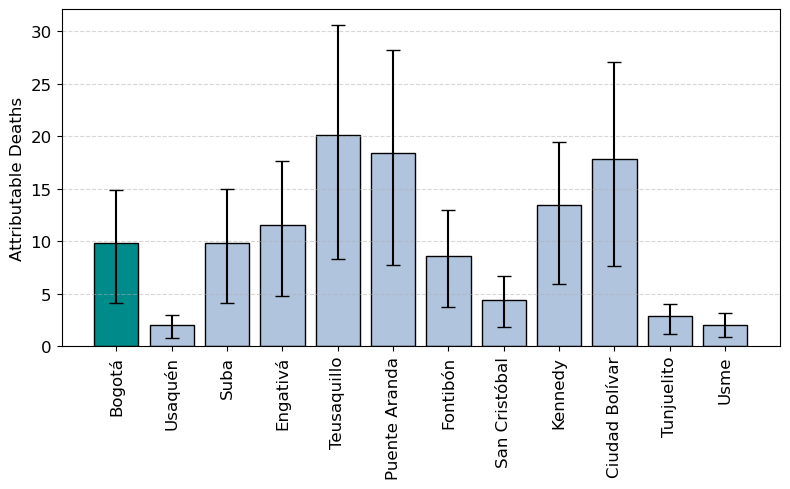

In [37]:
data = {
    'Location': [
        'Bogotá', 'Ciudad Bolívar', 'Engativá', 'Fontibón', 'Kennedy',
        'Puente Aranda', 'San Cristóbal', 'Suba', 'Teusaquillo',
        'Tunjuelito', 'Usaquén', 'Usme'
    ],
    'Deaths': [707, 107, 91, 30, 133, 45, 17, 107, 29, 5, 10, 7],
    'CI_low': [299, 46, 38, 13, 59, 19, 7, 45, 12, 2, 4, 3],
    'CI_high': [1076, 162, 139, 45, 193, 69, 26, 163, 44, 7, 15, 11]
}

desired_order = [
    'Bogotá', 'Usaquén', 'Suba', 'Engativá', 'Teusaquillo',
    'Puente Aranda', 'Fontibón', 'San Cristóbal', 'Kennedy',
    'Ciudad Bolívar', 'Tunjuelito', 'Usme'
]

df_man = pd.DataFrame(data)

# Agrega la población al DataFrame
# Convierte el DataFrame de población en un diccionario {localidad: población_media}
poblacion_dict = dict(zip(poblacion['LOCALIDAD_NOMBRE'], poblacion['POBLACION_MEDIA']))

# Usa .map() con ese diccionario
df_man['Poblacion'] = df_man['Location'].map(poblacion_dict)

# Calcula tasa por 100,000 habitantes
df_man['Tasa_100mil'] = (df_man['Deaths'] / df_man['Poblacion']) * 100000

# Muestra los resultados
print(df_man[['Location', 'Deaths', 'Poblacion', 'Tasa_100mil']])

# Calculate error margins
# CI en tasas por 100,000 habitantes
df_man['CI_low_rate'] = (df_man['CI_low'] / df_man['Poblacion']) * 100000
df_man['CI_high_rate'] = (df_man['CI_high'] / df_man['Poblacion']) * 100000

# Tasa media
df_man['Tasa_100mil'] = (df_man['Deaths'] / df_man['Poblacion']) * 100000

# Margen de error para yerr
df_man['err_low'] = df_man['Tasa_100mil'] - df_man['CI_low_rate']
df_man['err_high'] = df_man['CI_high_rate'] - df_man['Tasa_100mil']

df_man['Location'] = pd.Categorical(df_man['Location'], categories=desired_order, ordered=True)
df_man.sort_values('Location', inplace=True)

colors = ['darkcyan' if loc == 'Bogotá' else 'lightsteelblue' for loc in df_man['Location']]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(df_man['Location'], df_man['Tasa_100mil'], yerr=[df_man['err_low'], df_man['err_high']], capsize=5, 
        color=colors, edgecolor='k')
plt.xticks(rotation=90, fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Attributable Deaths', fontsize = 12)
#plt.title('Attributable Deaths by Location (Age 25+) with 95% CI', fontsize = 13)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
#plt.yscale('log')
plt.show()


/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

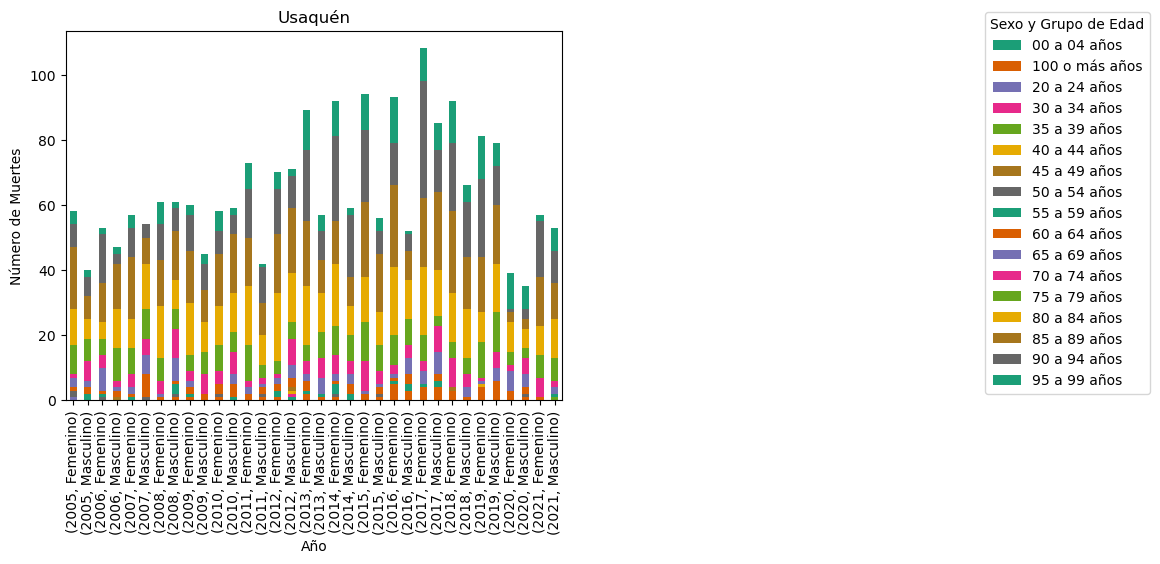

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

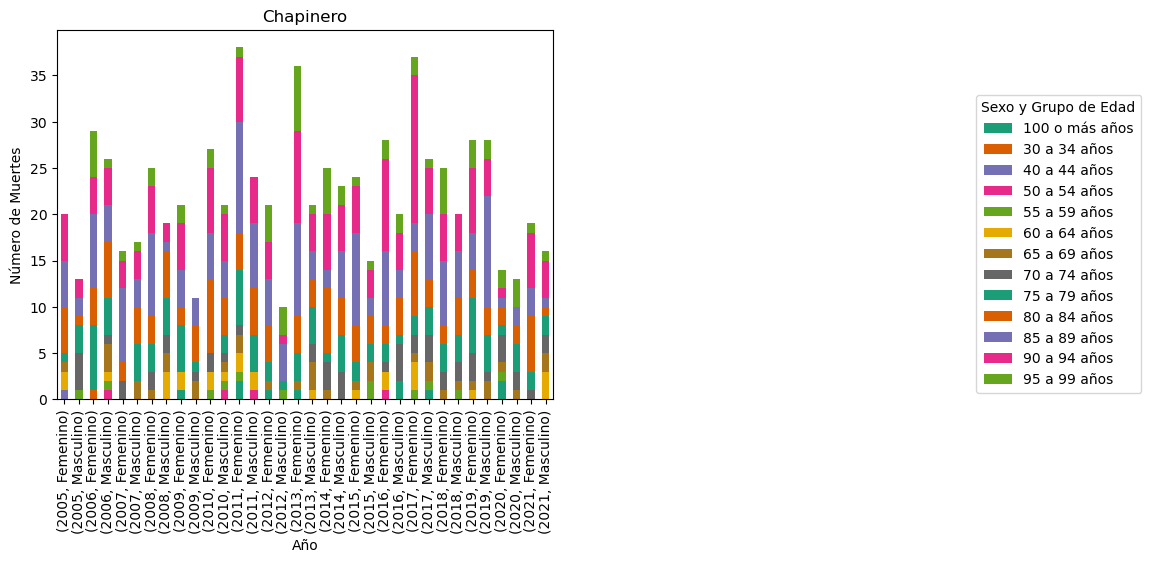

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

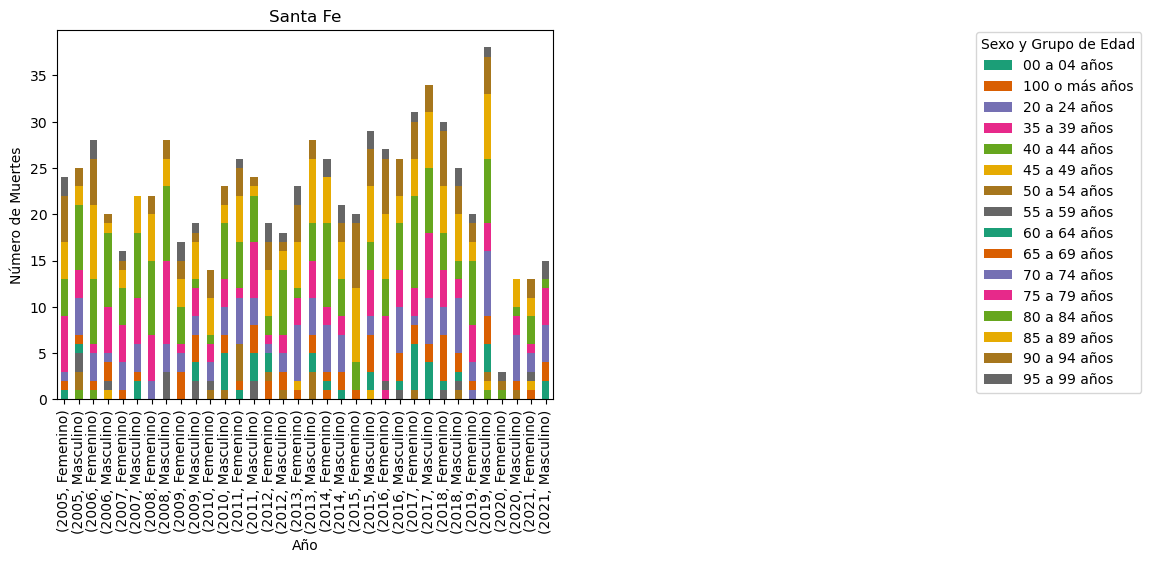

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

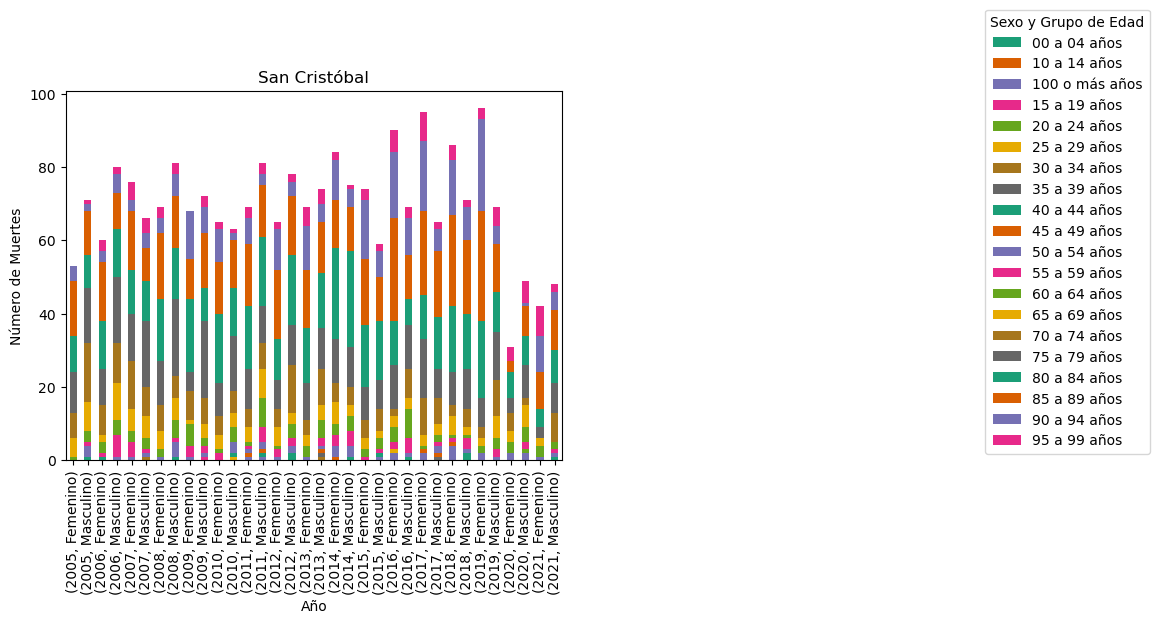

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

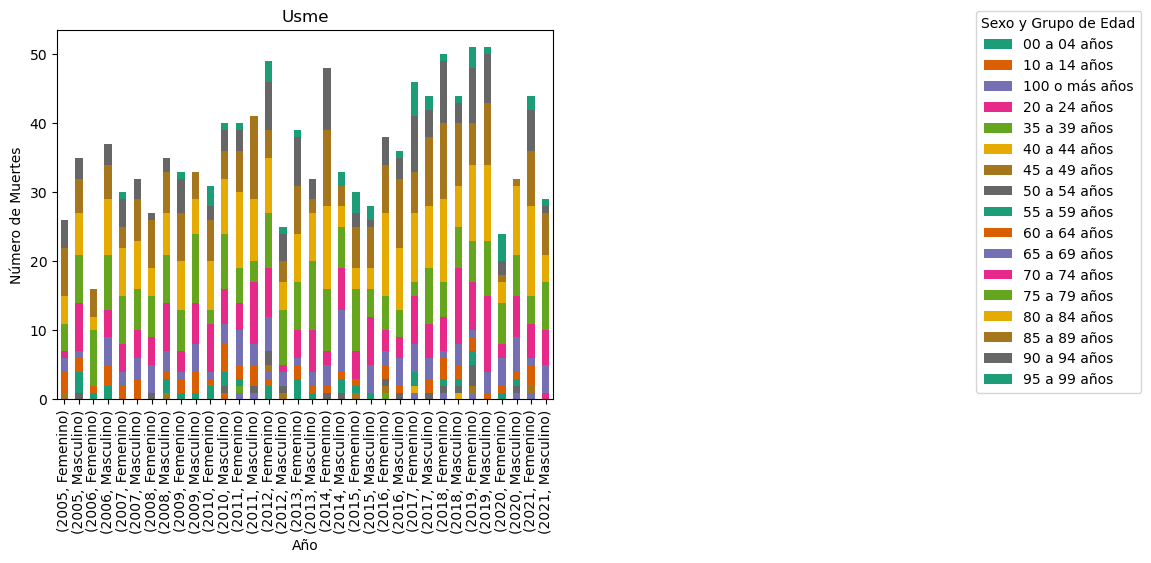

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

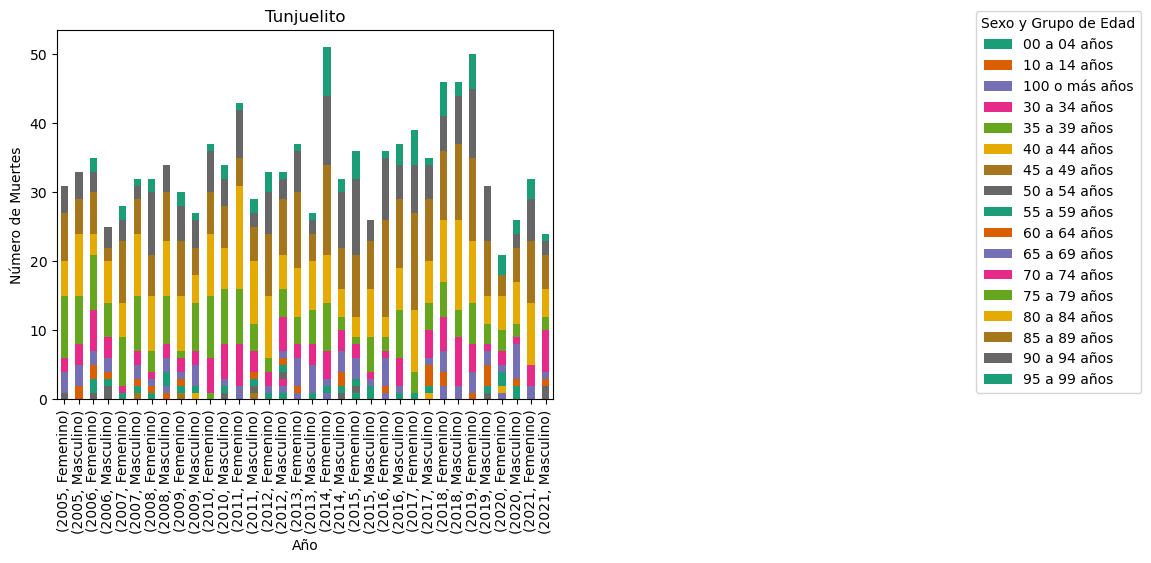

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

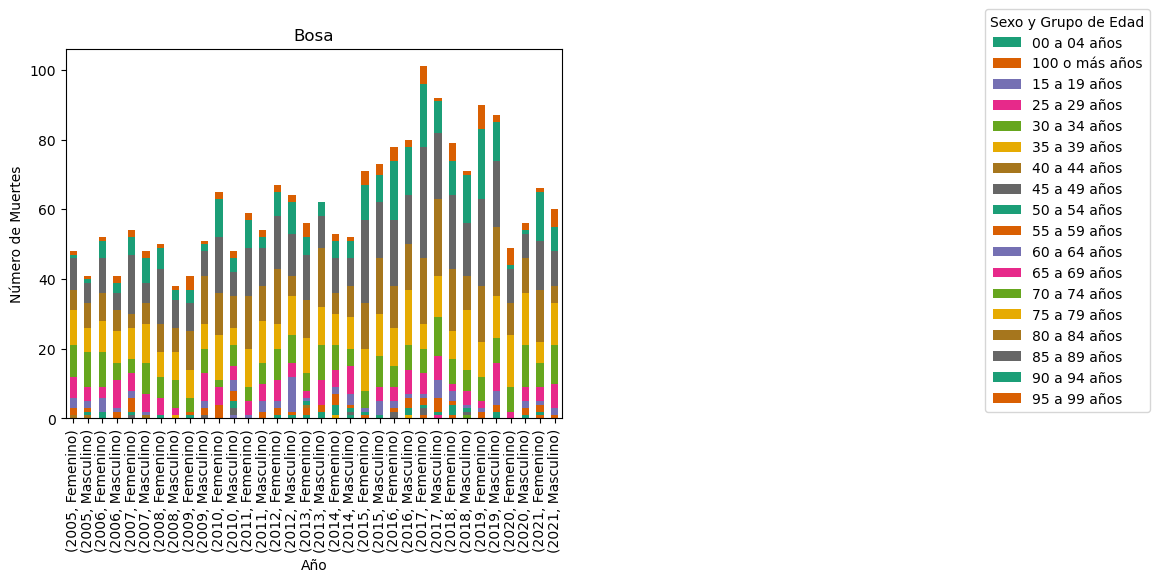

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

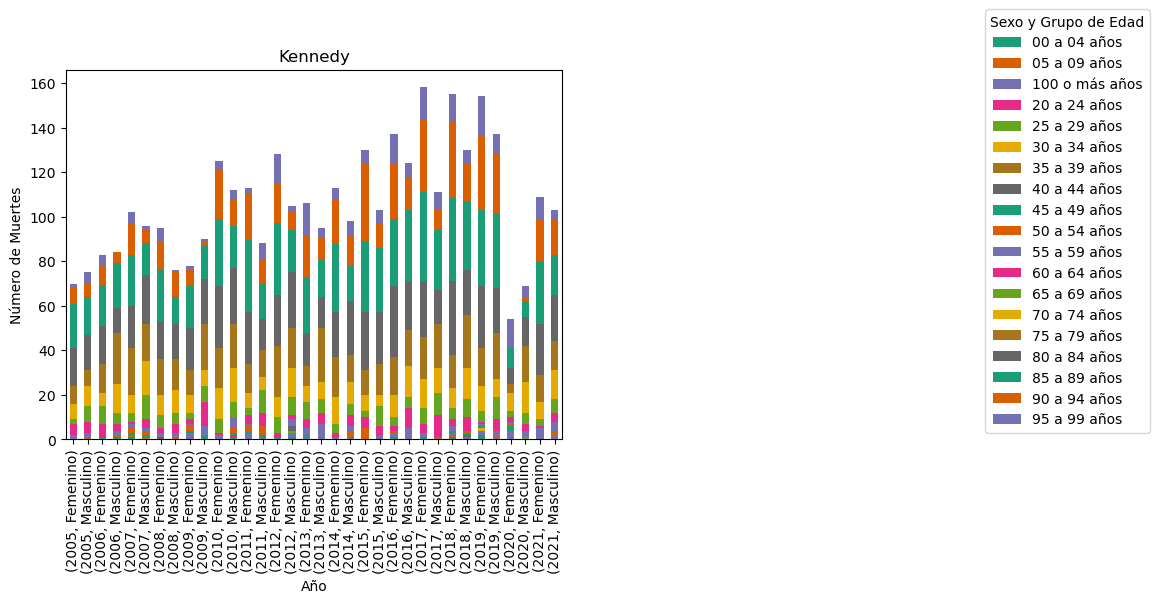

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

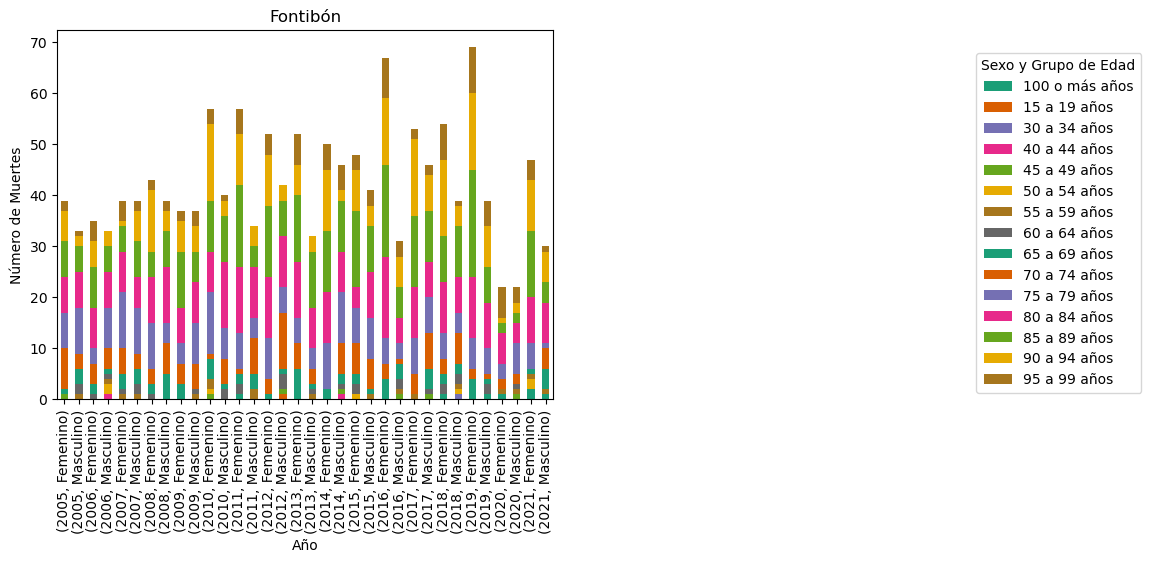

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

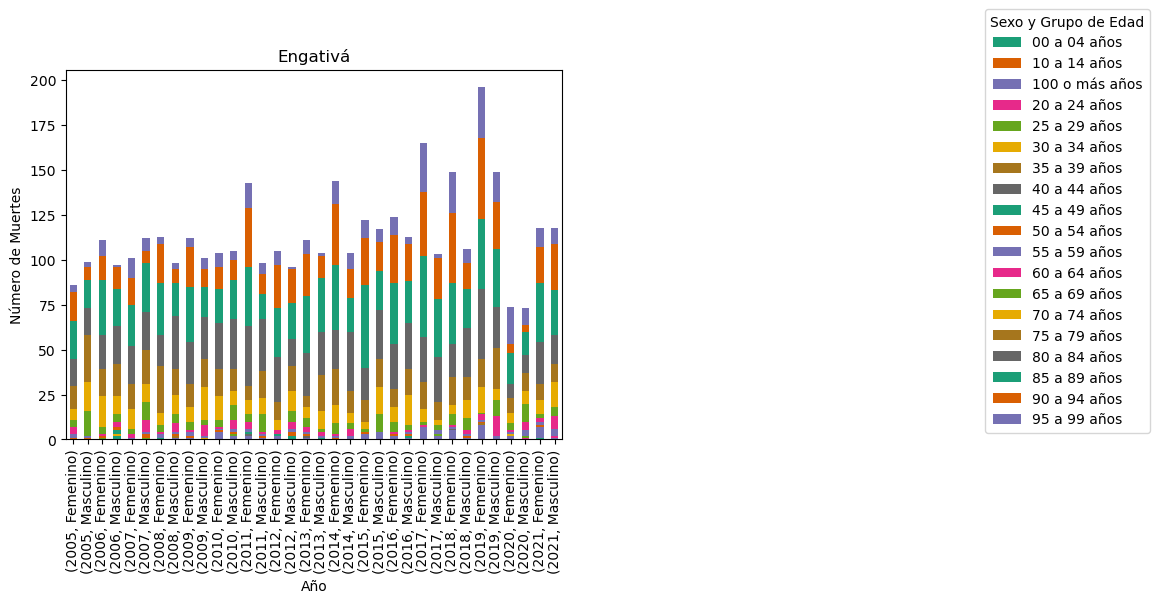

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

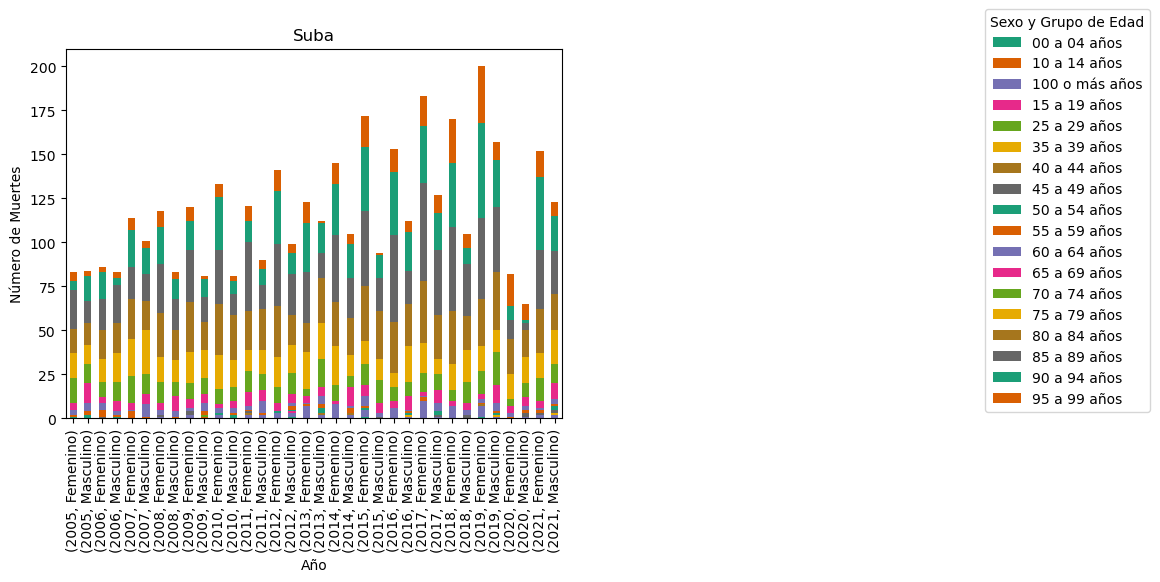

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

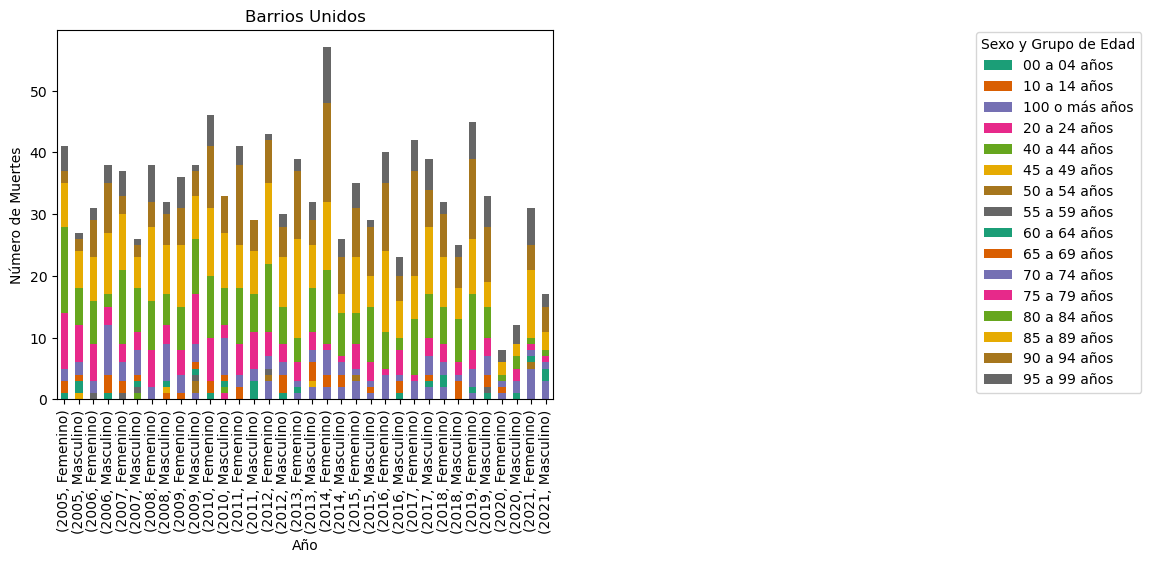

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

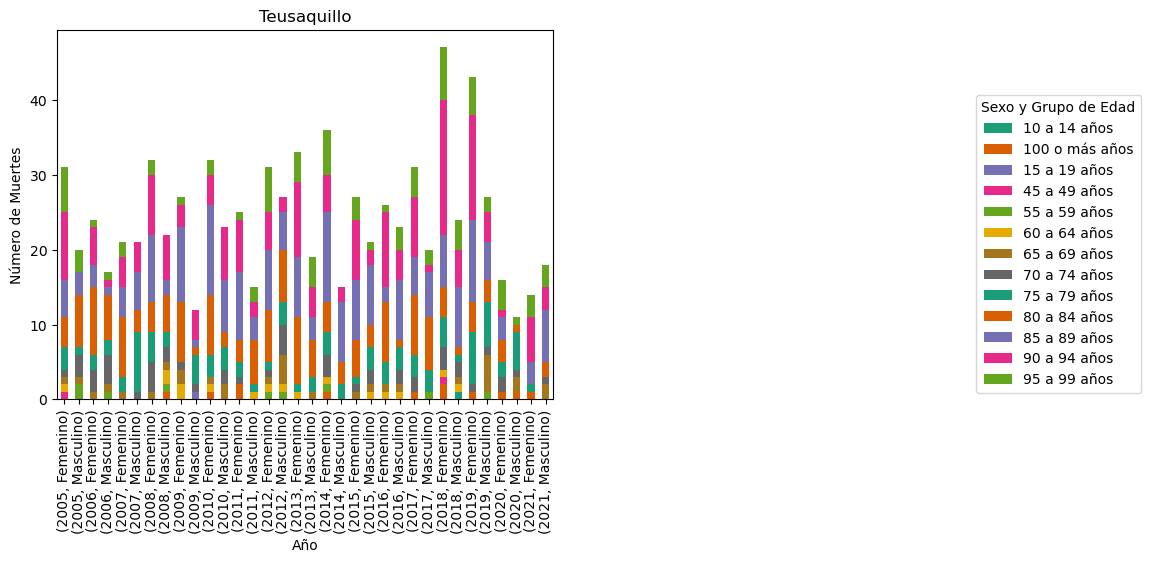

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

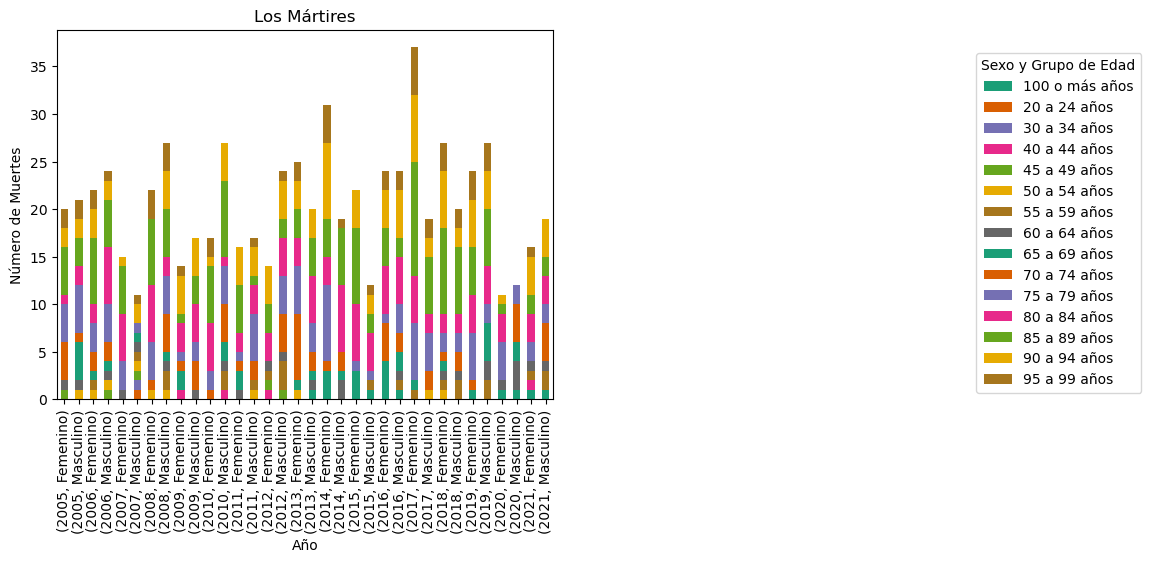

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

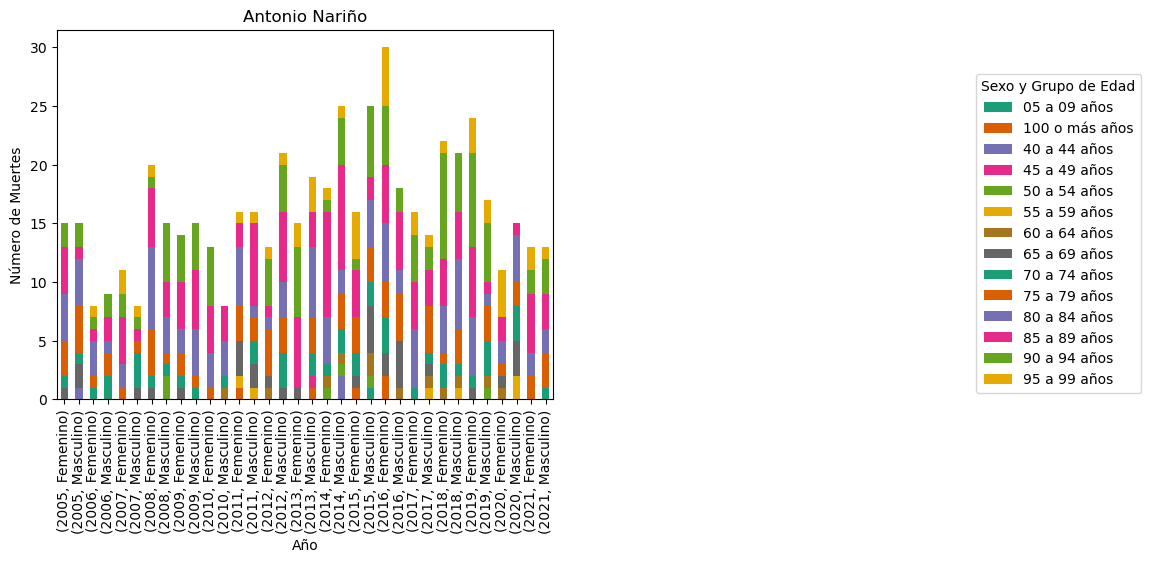

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

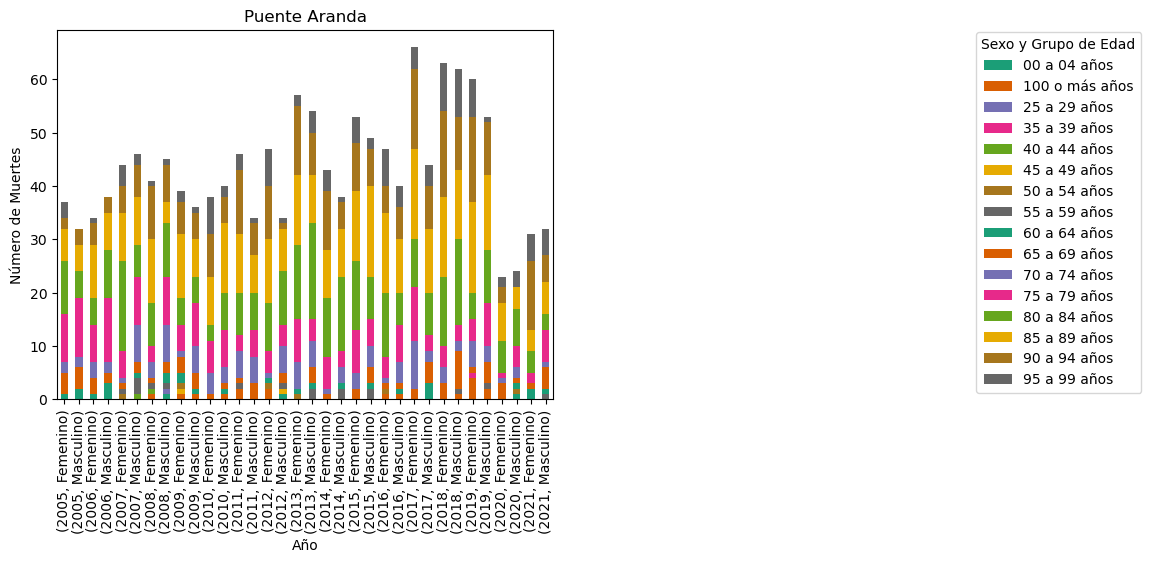

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

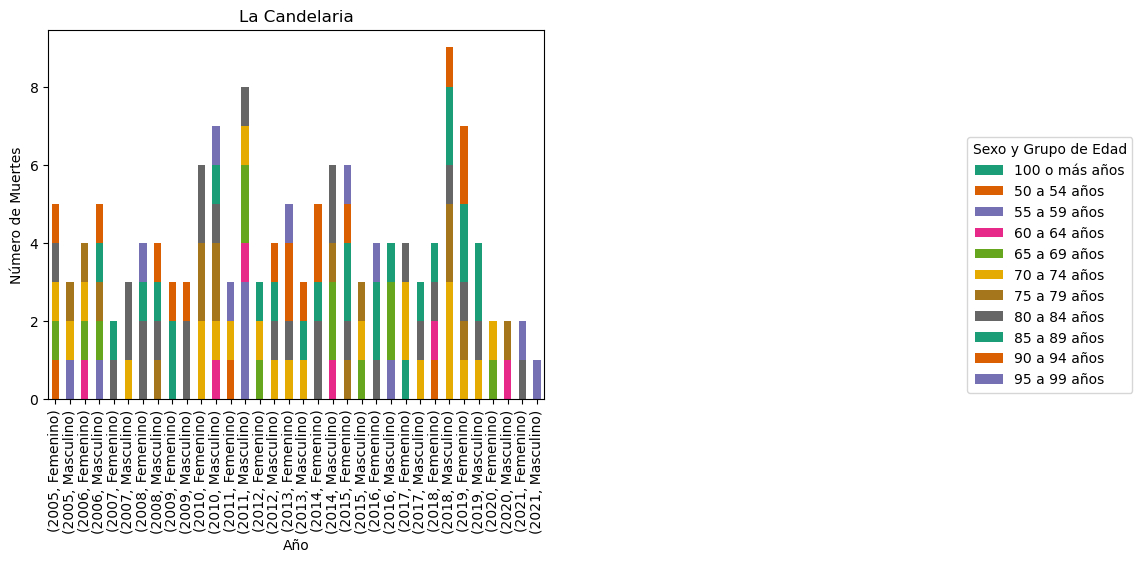

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

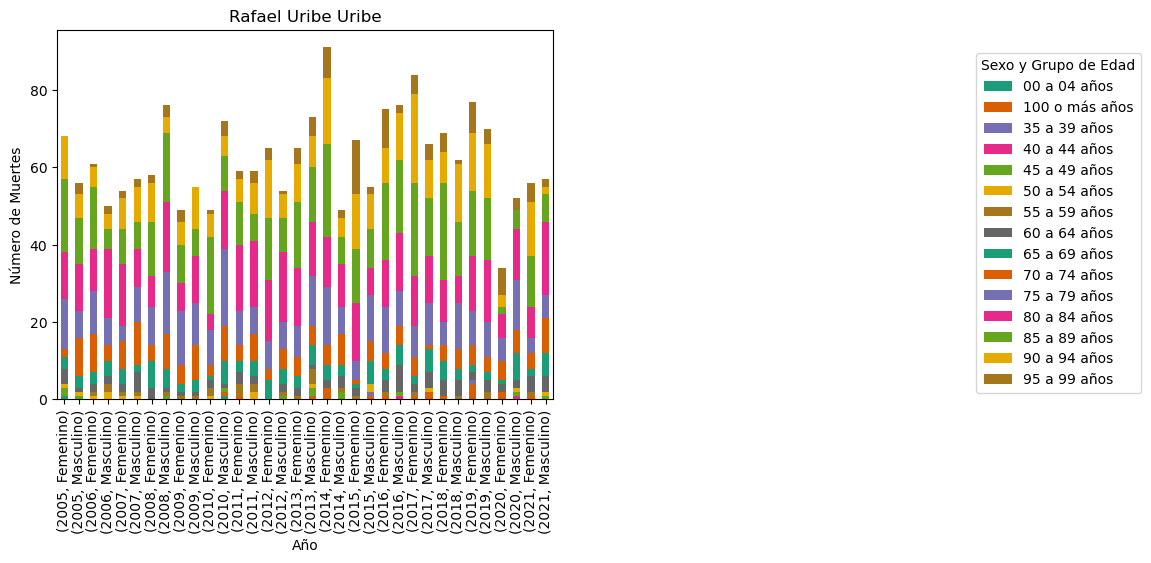

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

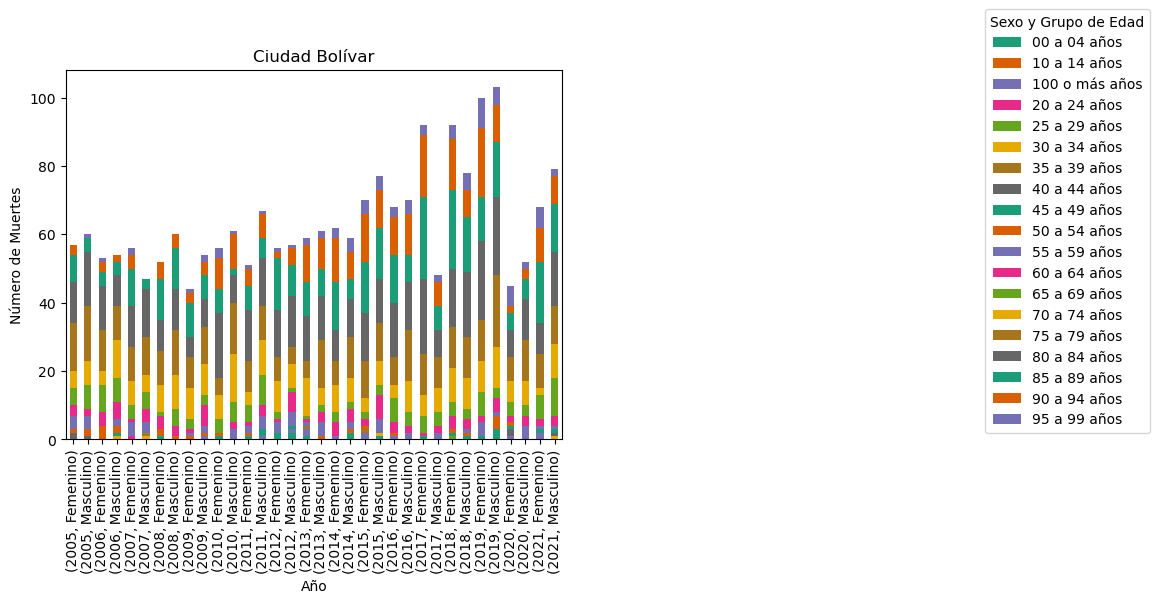

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

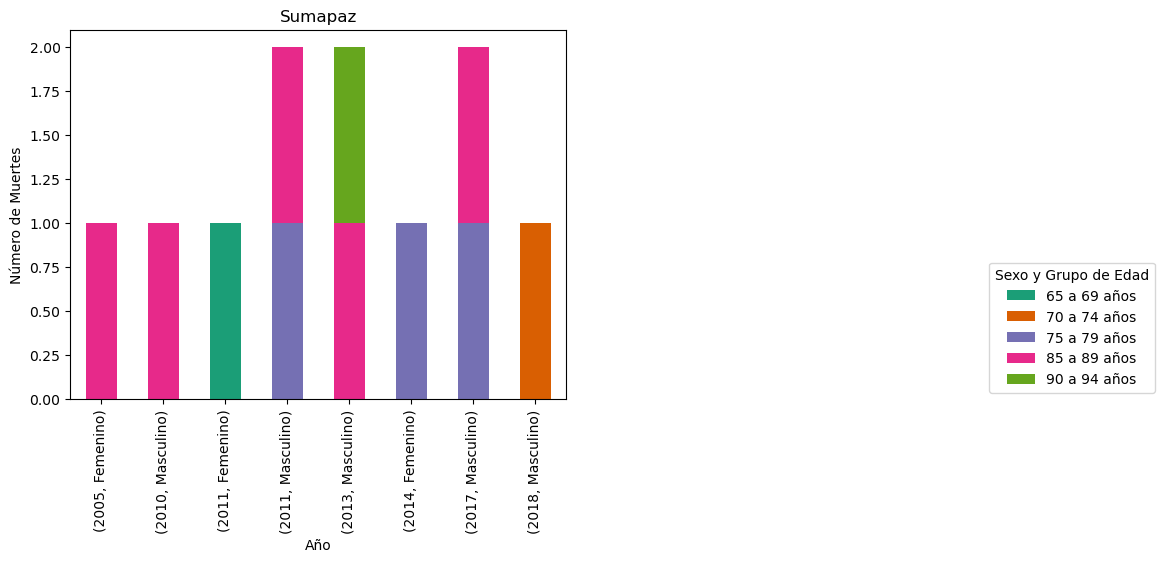

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_30495/2509802103.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2400x2000 with 0 Axes>

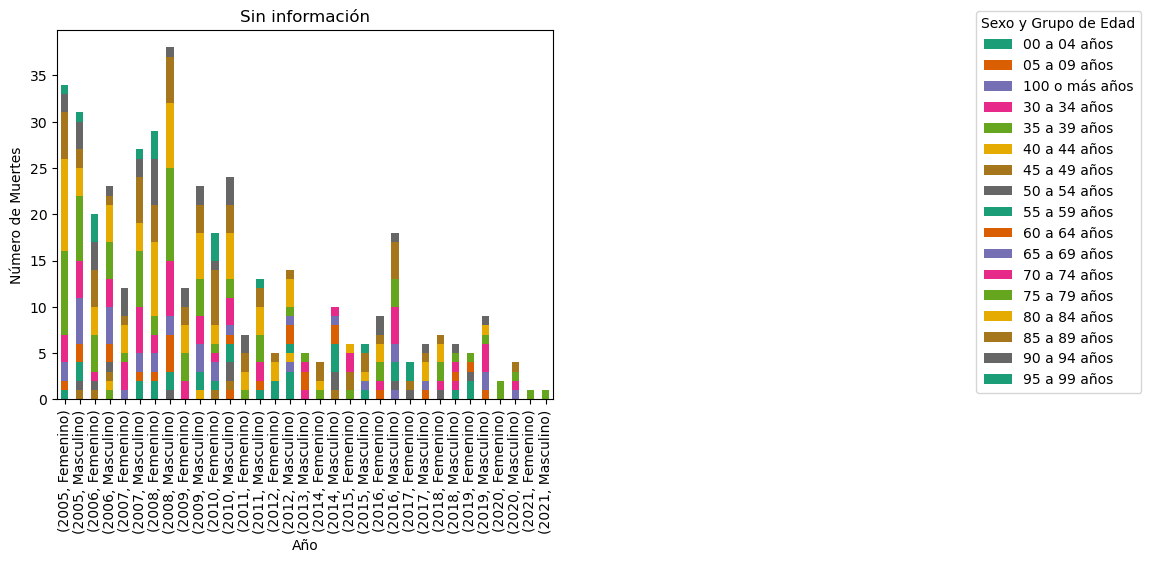

In [17]:
paleta_edad = sns.color_palette("Dark2", len(datos_filtrados.columns))

for localidad in localidades_unicas:
    datos_localidad = datos_filtrados[datos_filtrados['LOCALIDAD_NOMBRE'] == localidad]

    # Agrupar por año, sexo y grupo de edad, y contar las muertes
    datos_agrupados= datos_localidad.groupby(['ANIO', 'SEXO', 'EDAD_GRUPO'])['ANIO'].count().unstack().fillna(0)

    plt.figure(figsize=(24, 20))
    datos_agrupados.plot(kind='bar', color=paleta_edad, stacked=True)
    plt.legend(title='Sexo y Grupo de Edad', loc='lower right', bbox_to_anchor=(2, 0, 0.2, 1))
    plt.title(f'{localidad}')

    plt.xlabel('Año')
    plt.ylabel('Número de Muertes')

    plt.tight_layout()
    plt.show()

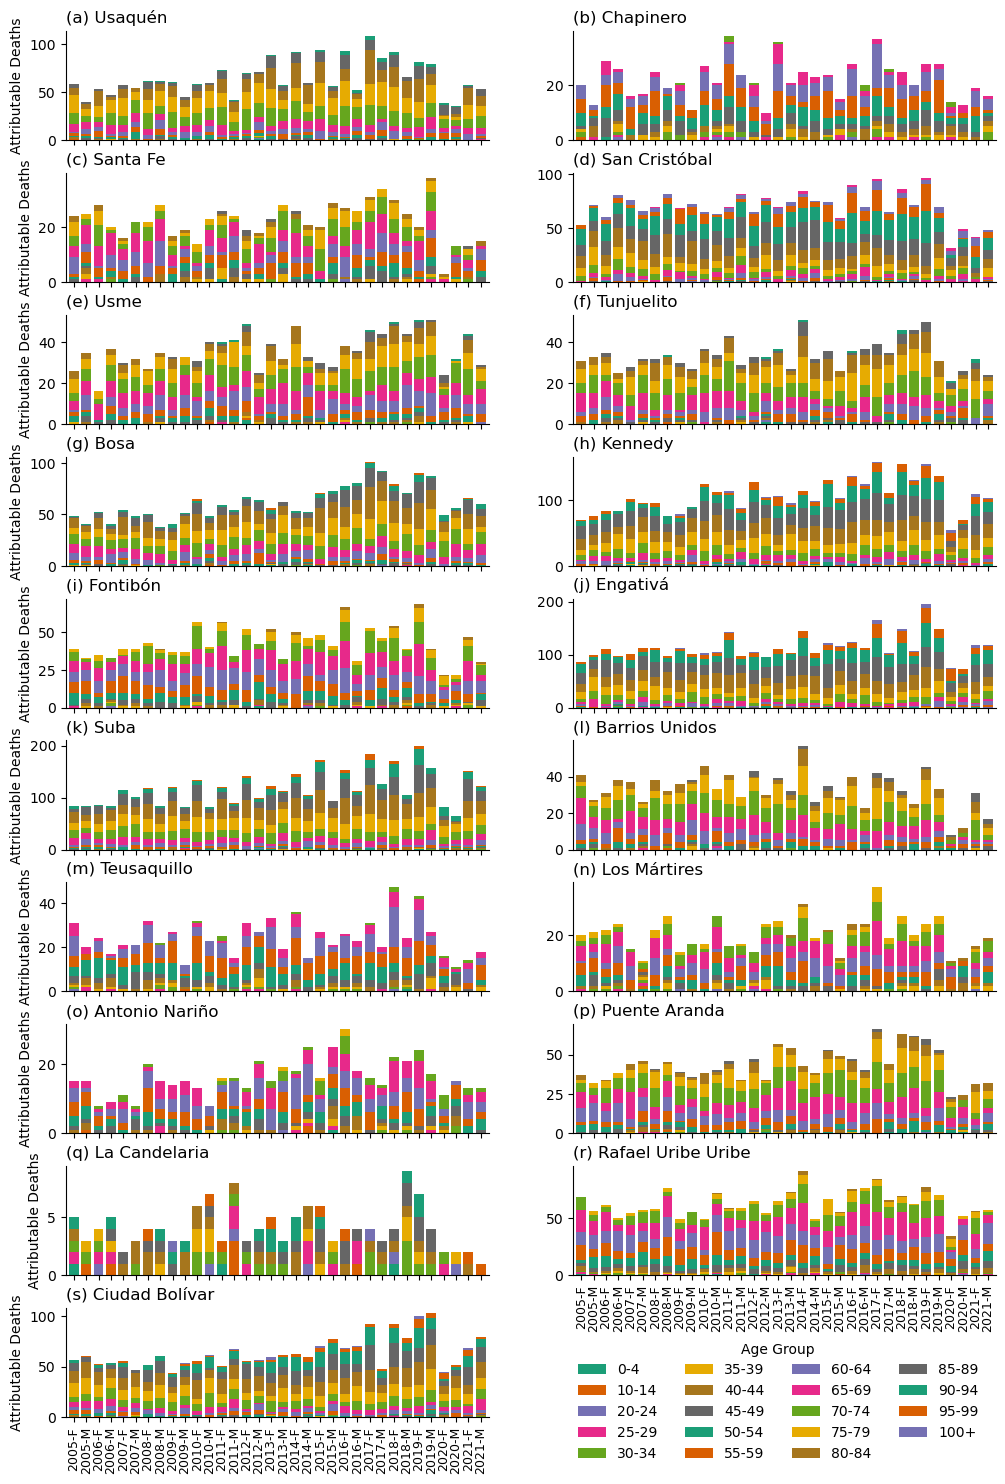

In [18]:
# Remove "Sin información" and "Sumapaz" from localities
datos_filtrados = datos_filtrados[
    ~datos_filtrados["LOCALIDAD_NOMBRE"].isin(["Sin información", "Sumapaz"])
]

# Unique localities
localidades_unicas = datos_filtrados["LOCALIDAD_NOMBRE"].unique()
n_localities = len(localidades_unicas)

# Define sorted age groups
sorted_age_groups = [
    "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39",
    "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", "75-79",
    "80-84", "85-89", "90-94", "95-99", "100+"
]

age_group_mapping = {"00 a 04 años": "0-4","05 a 09 años": "5-9", "10 a 14 años": "10-14",
                     "15 a 19 años": "15-19","20 a 24 años": "20-24","25 a 29 años": "25-29",
                     "30 a 34 años": "30-34","35 a 39 años": "35-39","40 a 44 años": "40-44",
                     "45 a 49 años": "45-49","50 a 54 años": "50-54","55 a 59 años": "55-59",
                     "60 a 64 años": "60-64","65 a 69 años": "65-69","70 a 74 años": "70-74",
                     "75 a 79 años": "75-79","80 a 84 años": "80-84","85 a 89 años": "85-89",
                     "90 a 94 años": "90-94","95 a 99 años": "95-99","100 o más años": "100+"
                    }

# Define a fixed color palette for age groups
paleta_edad = sns.color_palette("Dark2", len(sorted_age_groups))
color_dict = dict(zip(sorted_age_groups, paleta_edad))

# Set up figure with subplots (5 rows, 4 columns)
fig = plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(10, 2, wspace=0.2, hspace=0.3)

# Create labeled titles (a), (b), (c), etc.
titulo_labels = list("abcdefghijklmnopqrstuvwxyz")[:len(localidades_unicas)]

# Loop through each locality and create a subplot
for i, localidad in enumerate(localidades_unicas):
    row, col = divmod(i, 2)  # Get subplot position
    ax = plt.subplot(gs[row, col])

    # Filter data for locality
    datos_localidad = datos_filtrados[datos_filtrados["LOCALIDAD_NOMBRE"] == localidad]

    # Group data: Count deaths by year, sex, and age group
    datos_agrupados = datos_localidad.groupby(['ANIO', 'SEXO', 'EDAD_GRUPO'])['ANIO'].count().unstack().fillna(0)
    
    #pdb.set_trace()
    # Reorder columns based on the sorted age groups
    # Rename columns using the mapping
    datos_agrupados = datos_agrupados.rename(columns=age_group_mapping)

    # Ensure only existing age groups are reindexed (to avoid filling everything with 0s)
    existing_age_groups = [age for age in sorted_age_groups if age in datos_agrupados.columns]
    datos_agrupados = datos_agrupados.reindex(columns=existing_age_groups, fill_value=0)


    # Rename index for formatted x-axis labels (e.g., "2010-F", "2010-M")
    datos_agrupados.index = [
        f"{year}-F" if sex == "Femenino" else f"{year}-M"
        for year, sex in datos_agrupados.index
    ]

    # Plot stacked bar chart with consistent colors
    datos_agrupados.plot(kind="bar", stacked=True, ax=ax, width=0.8, color=[color_dict[age] for age in sorted_age_groups])

    # Titles and labels
    ax.set_title(f"({titulo_labels[i]}) {localidad}", loc="left", fontsize=12)
    ax.set_xlabel("")  # Remove x-labels except last row
    ax.set_ylabel("Attributable Deaths" if col == 0 else "", fontsize = 10)  # Y-label only on first column

    # Remove duplicate legends in individual plots
    plt.legend([], frameon=False)

    # X-axis settings: Only last row should show x labels
    if row == 9:  # Last row
        ax.set_xticks(range(len(datos_agrupados.index)))
        ax.set_xticklabels(datos_agrupados.index, rotation=90, fontsize=9)
    elif i == 17:
        ax.set_xticks(range(len(datos_agrupados.index)))
        ax.set_xticklabels(datos_agrupados.index, rotation=90, fontsize=9)
    else:
        ax.set_xticklabels([])
    

    # Remove spines for cleaner look
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if i == 18:
        # **Create the legend separately above the first row**
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, labels, title = 'Age Group', loc="upper center", ncol=4, 
                   fontsize=10, frameon=False, bbox_to_anchor=(1.685, 0.8), title_fontsize = 10)

#plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit legend
plt.show()


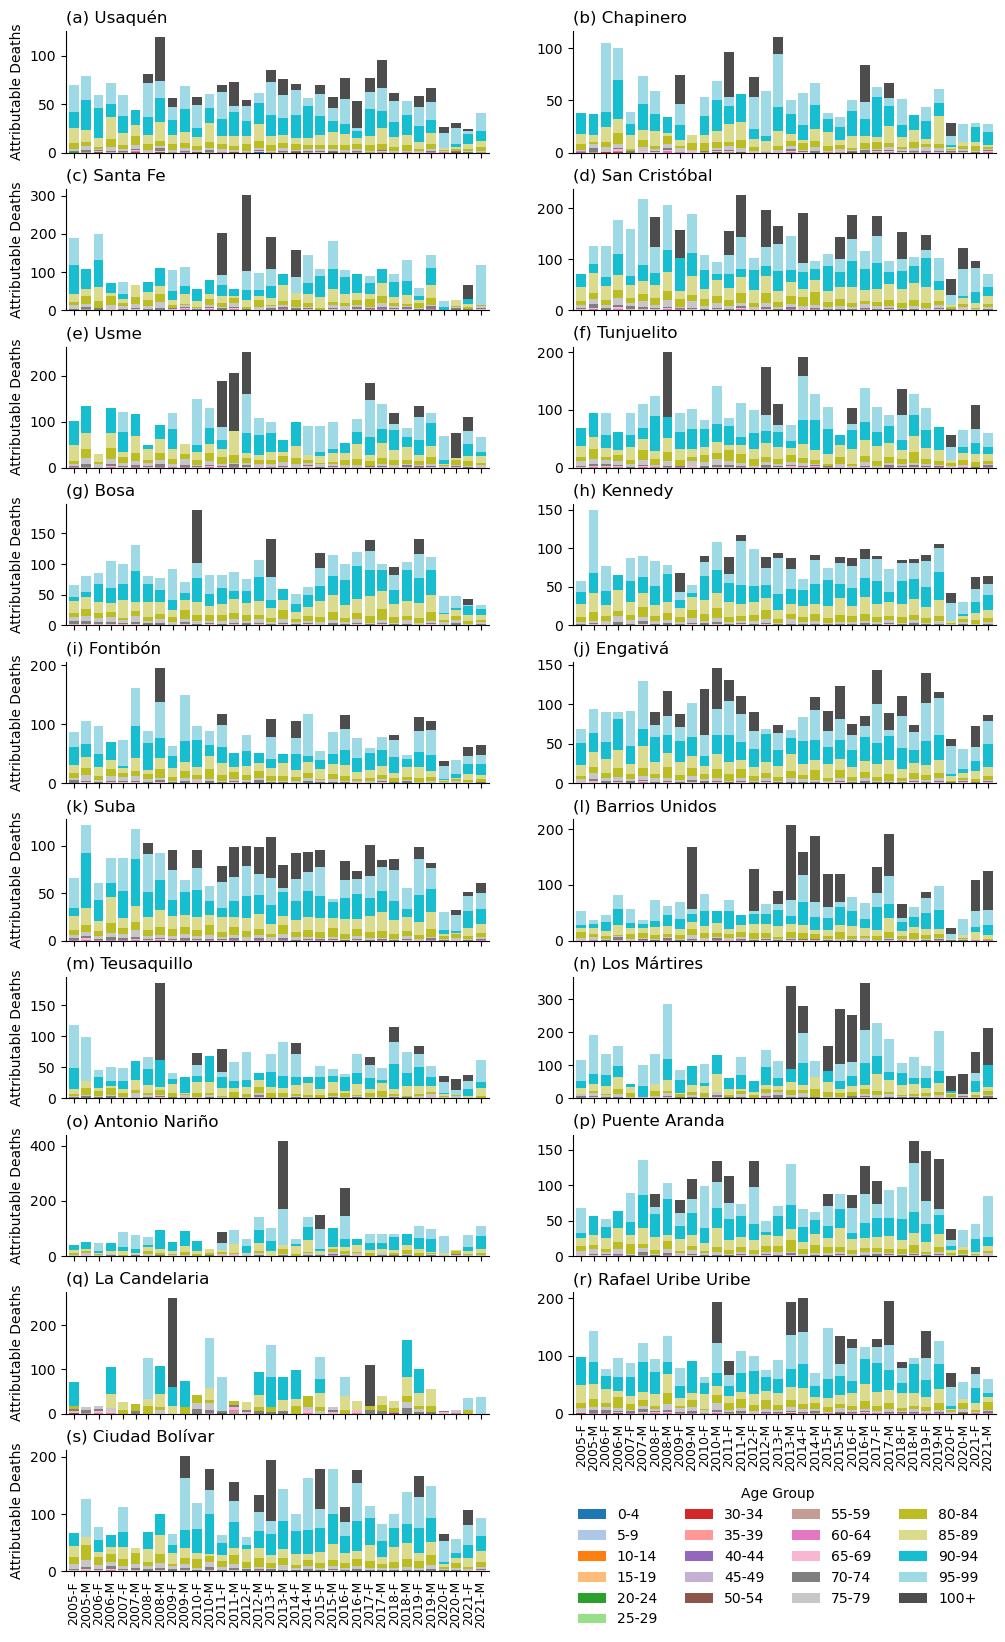

In [19]:
def get_age_group(edad):
    if edad >= 100:
        return "100+"
    else:
        low = (edad // 5) * 5
        high = low + 4
        return f"{low}-{high}"
    
# Merge population data
tmp_h['SEXO'] = 'Hombres'
tmp_m['SEXO'] = 'Mujeres'
poblacion_df = pd.concat([tmp_h, tmp_m])

poblacion_df['EDAD_GRUPO'] = poblacion_df['Edad'].apply(get_age_group)

poblacion_df['SEXO'] = poblacion_df['SEXO'].map({'Hombres': 'Masculino', 'Mujeres': 'Femenino'})

poblacion_df = poblacion_df[
    ~poblacion_df["LOCALIDAD_NOMBRE"].isin(["Sin información", "Sumapaz"])
]

# Age group mapping and order
sorted_age_groups = [
    "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39",
    "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", "75-79",
    "80-84", "85-89", "90-94", "95-99", "100+"
]

age_group_mapping = {
    "00 a 04": "0-4", "00 a 04 años": "0-4",
    "05 a 09": "5-9", "05 a 09 años": "5-9",
    "10 a 14": "10-14", "10 a 14 años": "10-14",
    "15 a 19": "15-19", "15 a 19 años": "15-19",
    "20 a 24": "20-24", "20 a 24 años": "20-24",
    "25 a 29": "25-29", "25 a 29 años": "25-29",
    "30 a 34": "30-34", "30 a 34 años": "30-34",
    "35 a 39": "35-39", "35 a 39 años": "35-39",
    "40 a 44": "40-44", "40 a 44 años": "40-44",
    "45 a 49": "45-49", "45 a 49 años": "45-49",
    "50 a 54": "50-54", "50 a 54 años": "50-54",
    "55 a 59": "55-59", "55 a 59 años": "55-59",
    "60 a 64": "60-64", "60 a 64 años": "60-64",
    "65 a 69": "65-69", "65 a 69 años": "65-69",
    "70 a 74": "70-74", "70 a 74 años": "70-74",
    "75 a 79": "75-79", "75 a 79 años": "75-79",
    "80 a 84": "80-84", "80 a 84 años": "80-84",
    "85 a 89": "85-89", "85 a 89 años": "85-89",
    "90 a 94": "90-94", "90 a 94 años": "90-94",
    "95 a 99": "95-99", "95 a 99 años": "95-99",
    "100 o más": "100+", "100 o más años": "100+"
}

# Define target values from mapping
target_age_groups = set(age_group_mapping.values())

# For datos_filtrados
if not set(datos_filtrados['EDAD_GRUPO'].dropna().unique()).issubset(target_age_groups):
    datos_filtrados['EDAD_GRUPO'] = datos_filtrados['EDAD_GRUPO'].map(age_group_mapping)

poblacion_agrupada = (
    poblacion_df
    .groupby(['ANIO', 'SEXO', 'EDAD_GRUPO', 'LOCALIDAD_NOMBRE'], as_index=False)['Población']
    .sum()
)

# Fixed color palette
# Use tab20 and add one more distinguishable color (21 total)
base_colors = sns.color_palette("tab20")
extra_color = [(0.3, 0.3, 0.3)]  # e.g., dark gray
paleta_edad = base_colors + extra_color

# Map to dictionary
color_dict = dict(zip(sorted_age_groups, paleta_edad))

# Unique localities
localidades_unicas = datos_filtrados["LOCALIDAD_NOMBRE"].unique()
titulo_labels = list("abcdefghijklmnopqrstuvwxyz")[:len(localidades_unicas)]

# Set up grid for plots
n_localities = len(localidades_unicas)
n_cols = 2
n_rows = (n_localities + n_cols - 1) // n_cols  # Ceiling division

fig = plt.figure(figsize=(12, n_rows * 2))
gs = gridspec.GridSpec(n_rows, n_cols, wspace=0.2, hspace=0.3)

for i, localidad in enumerate(localidades_unicas):
    row, col = divmod(i, 2)
    ax = plt.subplot(gs[row, col])

    # Filter deaths and population by locality
    
    datos_localidad = datos_filtrados[datos_filtrados["LOCALIDAD_NOMBRE"] == localidad]
    poblacion_localidad = poblacion_agrupada[poblacion_agrupada["LOCALIDAD_NOMBRE"] == localidad]
    
    # Deaths grouped by year, sex, and age group
    datos_muertes = (
        datos_localidad
        .groupby(['ANIO', 'SEXO', 'EDAD_GRUPO','LOCALIDAD_NOMBRE'])['ANIO']
        .count()
        .reset_index(name='muertes')
    )
    
    # Merge with population
    merged = pd.merge(
        datos_muertes,
        poblacion_localidad,
        on=['ANIO', 'SEXO', 'EDAD_GRUPO', 'LOCALIDAD_NOMBRE'],
        how='left'
    )
    
    # Death rate per 100,000
    merged['rate'] = (merged['muertes'] / merged['Población']) * 1000
    
    # Pivot to wide format
    datos_agrupados = (
        merged
        .pivot_table(index=['ANIO', 'SEXO'], columns='EDAD_GRUPO', values='rate')
        .fillna(0)
    )

    # Reorder and rename columns
    datos_agrupados = datos_agrupados.reindex(columns=sorted_age_groups, fill_value=0)

    # Index for x-axis labels
    datos_agrupados.index = [
        f"{year}-F" if sex == "Femenino" else f"{year}-M"
        for year, sex in datos_agrupados.index
    ]

    # Plot
    if not datos_agrupados.empty:
        datos_agrupados.plot(
            kind="bar",
            stacked=True,
            ax=ax,
            width=0.8,
            color=[color_dict[age] for age in sorted_age_groups]
        )
        # (Continue with title, labels, etc.)
    else:
        ax.set_visible(False)  # optionally hide the subplot if no data

    ax.set_title(f"({titulo_labels[i]}) {localidad}", loc="left", fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("Attributable Deaths" if col == 0 else "", fontsize=10)
    plt.legend([], frameon=False)

    if row == 9 or i == 17:
        ax.set_xticks(range(len(datos_agrupados.index)))
        ax.set_xticklabels(datos_agrupados.index, rotation=90, fontsize=9)
    else:
        ax.set_xticklabels([])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if i == 18:
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(
            handles, labels, title='Age Group', loc="upper center", ncol=4,
            fontsize=10, frameon=False, bbox_to_anchor=(1.685, 0.8),
            title_fontsize=10
        )

plt.show()


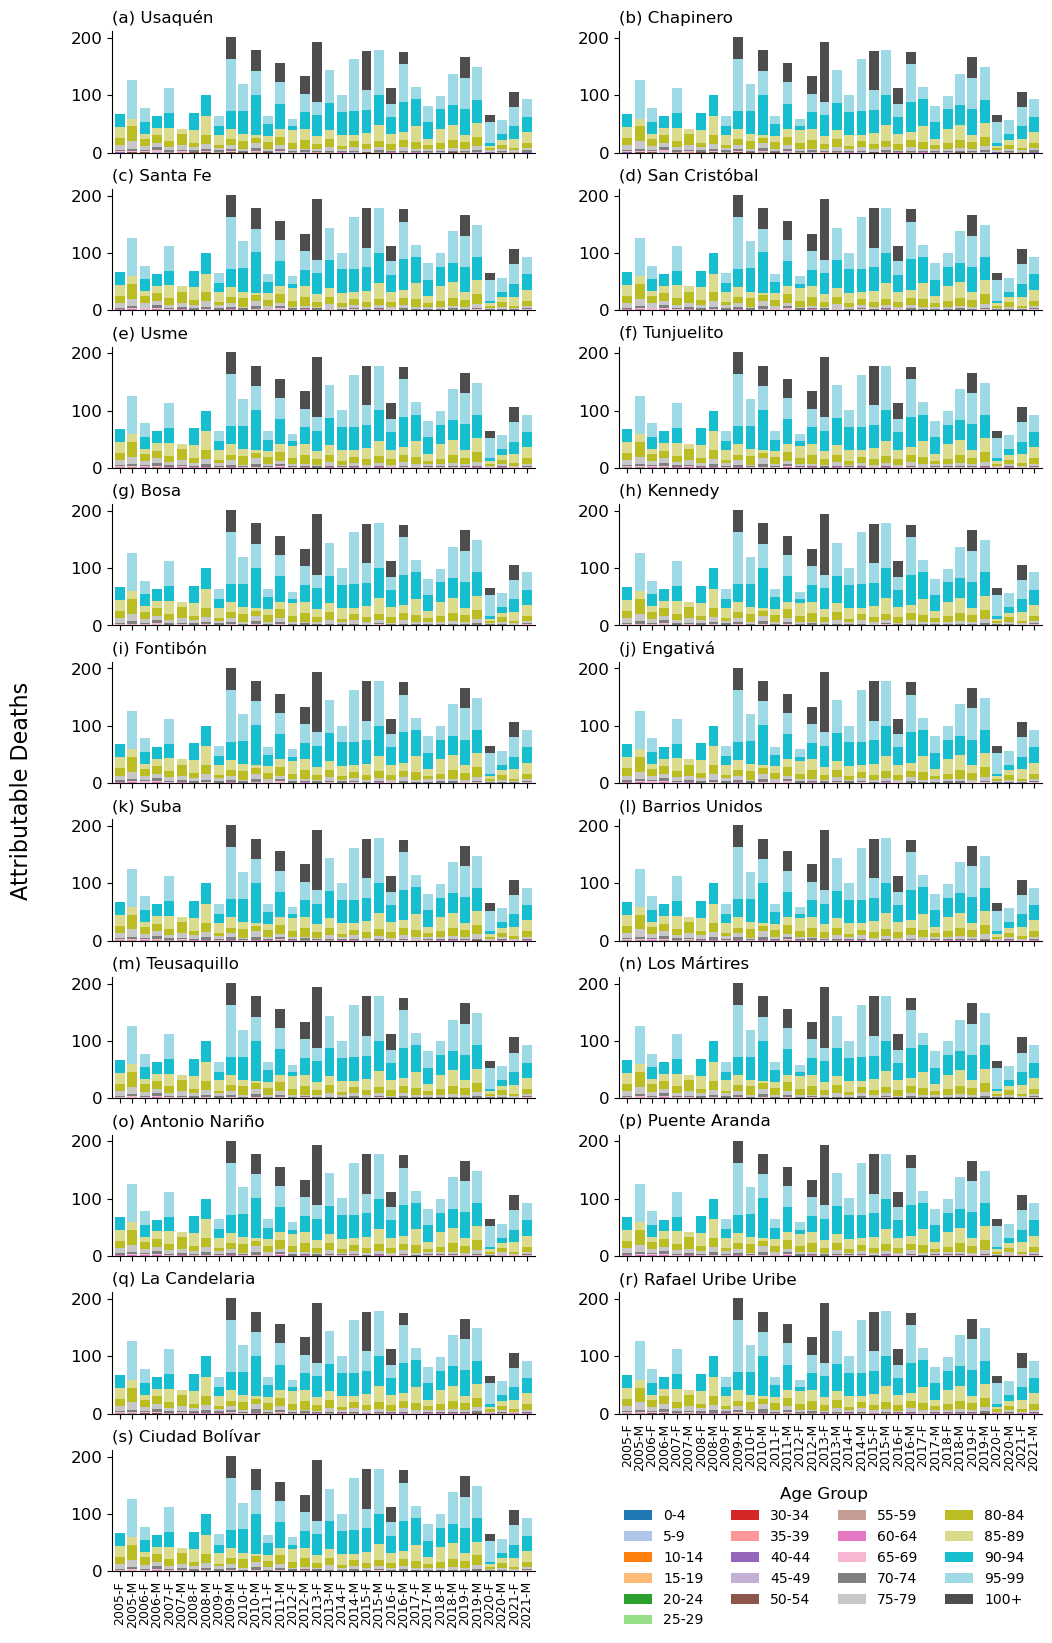

In [20]:
fig = plt.figure(figsize=(12, n_rows * 2))
gs = gridspec.GridSpec(n_rows, n_cols, wspace=0.2, hspace=0.3)

for i, localidad in enumerate(localidades_unicas):
    row, col = divmod(i, 2)
    ax = plt.subplot(gs[row, col])

    # (Tu procesamiento de datos...)

    if not datos_agrupados.empty:
        datos_agrupados.plot(
            kind="bar",
            stacked=True,
            ax=ax,
            width=0.8,
            color=[color_dict[age] for age in sorted_age_groups]
        )
    else:
        ax.set_visible(False)

    ax.set_title(f"({titulo_labels[i]}) {localidad}", loc="left", fontsize=12)
    ax.set_xlabel("")
    # Aquí removemos la etiqueta individual del eje y
    # ax.set_ylabel("Attributable Deaths" if col == 0 else "", fontsize=10)
    plt.legend([], frameon=False)

    if row == 9 or i == 17:
        ax.set_xticks(range(len(datos_agrupados.index)))
        ax.set_xticklabels(datos_agrupados.index, rotation=90, fontsize=9)
    else:
        ax.set_xticklabels([])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis='y', labelsize=12)

    if i == 18:
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(
            handles, labels, title='Age Group', loc="upper center", ncol=4,
            fontsize=10, frameon=False, bbox_to_anchor=(1.685, 0.8),
            title_fontsize=12
        )

# Etiqueta global para el eje y
fig.text(0.04, 0.5, 'Attributable Deaths', va='center', rotation='vertical', fontsize=16)

plt.show()


In [21]:
datos_filtrados['COUNT_OF_DEATHS'] = 1
df_agg = (
    datos_filtrados
    .groupby(['ANIO', 'SEXO', 'LOCALIDAD_NOMBRE', 'EDAD_GRUPO'], dropna=False)['COUNT_OF_DEATHS']
    .sum()
    .reset_index()
)

In [22]:
# Function to extract numeric midpoint from age group labels
def convert_age_group_to_numeric(age_group):
    """
    Converts an age group string (e.g., "20 a 24 años") to the numeric midpoint.
    """
    match = re.search(r"(\d+)\s*a\s*(\d+)", str(age_group))
    if match:
        lower, upper = map(int, match.groups())
        return (lower + upper) / 2  # Compute midpoint
    elif "y más" in str(age_group):  # Special case for "90 y más"
        return 95  # Assign 95 as an approximation for 90+
    else:
        return np.nan  
    
# Replace numeric age with categorical labels
def convert_age_numeric_to_label(age_numeric):
    """Convert numeric age midpoints to categorical labels"""
    return age_bins.get(age_numeric, "Unknown")

# Function to generate hexbin plots using a 4-column layout
def plot_hexbin_deaths(datos_filtrados, gridsize=30, cmap="viridis"):
    """
    Creates hexbin plots for multiple localities using a **4-column** layout.
    - **3 columns for plots, 1 column for colorbars**
    - **X-axis: Year (ANIO), Y-axis: Age Group (converted to numeric), Color: Frequency count**
    - **Logarithmic binning for better visibility**
    
    Args:
        datos_filtrados (pd.DataFrame): Filtered dataset containing deaths, age group, and year.
        gridsize (int): Grid size for hexbins (default=30).
        cmap (str): Colormap for hexbin plots.
    """
    
    
    # Remove "Sin informacion" from localities
    datos_filtrados = datos_filtrados[datos_filtrados["LOCALIDAD_NOMBRE"] != "Sin información"].copy()

    localidades_unicas = datos_filtrados["LOCALIDAD_NOMBRE"].unique()
    n_localities = len(localidades_unicas)
    n_cols = 4  # Set 4 columns (3 plots + 1 for colorbars)
    n_plot_cols = 3  # Number of plot columns (excluding colorbars)
    n_rows = int(np.ceil(n_localities / n_plot_cols))  # Compute required rows

    # Convert age group to numeric
    datos_filtrados["EDAD_GRUPO_NUMERIC"] = datos_filtrados["EDAD_GRUPO"].apply(convert_age_group_to_numeric)
    # Apply conversion to the dataset
    datos_filtrados["EDAD_GRUPO_LABEL"] = datos_filtrados["EDAD_GRUPO_NUMERIC"].map(convert_age_numeric_to_label)

    # Unique sorted numeric values for y-axis ticks
    sorted_age_numeric = sorted(age_bins.keys())

    # Filter valid numeric values
    datos_filtrados = datos_filtrados.dropna(subset=["ANIO", "EDAD_GRUPO_NUMERIC"])
    datos_filtrados["ANIO"] = pd.to_numeric(datos_filtrados["ANIO"], errors="coerce")

    # Compute global limits for consistency
    valid_ages = datos_filtrados["EDAD_GRUPO_NUMERIC"].dropna()
    valid_years = datos_filtrados["ANIO"].dropna()

    if valid_ages.empty or valid_years.empty:
        print("Error: No valid data found for plotting.")
        return

    x_min, x_max = valid_years.min(), valid_years.max()
    y_min, y_max = valid_ages.min(), valid_ages.max()
    titulo = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)',
              '(m)','(n)','(o)','(p)','(q)','(r)','(s)','(t)','(u)']
    year_label = [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]

    # Compute global vmin/vmax safely
    all_counts = []
    for localidad in localidades_unicas:
        df_localidad = datos_filtrados[datos_filtrados["LOCALIDAD_NOMBRE"] == localidad]
        if df_localidad.empty:
            continue
        hb_counts, _, _ = np.histogram2d(df_localidad["ANIO"], df_localidad["EDAD_GRUPO_NUMERIC"], bins=gridsize)
        all_counts.append(hb_counts)

    # Flatten the list and compute valid min/max
    if all_counts:
        all_counts = np.concatenate(all_counts).flatten()
        vmin, vmax = np.percentile(all_counts[all_counts > 0], [2, 98]) if all_counts.size > 0 else (1, 10)
    else:
        vmin, vmax = 1, 10

    # Create figure with a 4-column layout
    fig = plt.figure(figsize=(18, 4 * n_rows))
    gs = gridspec.GridSpec(n_rows, n_cols, width_ratios=[1, 1, 1, 0.1])  # 3 plots + 1 colorbar column

    hexbin_collections = []
    colorbar_axes = []

    for i, localidad in enumerate(localidades_unicas):
        row, col = divmod(i, n_plot_cols)  # Calculate row and column index for each locality
        ax = plt.subplot(gs[row, col])

        # Filter data for the locality
        df_localidad = datos_filtrados[datos_filtrados["LOCALIDAD_NOMBRE"] == localidad]
        if df_localidad.empty:
            ax.axis("off")  # Hide empty plots
            continue

        # Hexbin plot
        hb = ax.hexbin(
            df_localidad["ANIO"], df_localidad["EDAD_GRUPO_NUMERIC"], gridsize=gridsize, cmap=cmap,
            bins=None, mincnt=1, vmin=vmin, vmax=vmax, edgecolors='none'
        )

        hexbin_collections.append(hb)
        ax.set_title(f"{titulo[i]} {localidad}", fontsize=14, loc = 'left')

        # Set labels only on specific axes
        if col == 0:  # First column
            ax.set_ylabel("Age Group", fontsize=12)
            ax.set_yticks(sorted_age_numeric)
            ax.set_yticklabels([age_bins[age] for age in sorted_age_numeric], fontsize=10)
        else:
            ax.set_ylabel("")
            ax.set_yticks(sorted_age_numeric)
            ax.set_yticklabels([])

        # X-axis labels only on the last row
        if row == n_rows - 1:
            #ax.set_xlabel("Year", fontsize=12)
            ax.set_xticks(year_label)
            ax.set_xticklabels(year_label, rotation=90, fontsize=10)
        else:
            ax.set_xticklabels([])

        # Special case: the row before the last in the third column should have xticks and xlabel
        if row == n_rows - 2 and col == 2:
            #ax.set_xlabel("Year", fontsize=12)
            ax.set_xticks(year_label)
            ax.set_xticklabels(year_label, rotation=90, fontsize=10)
            

    # Hide any remaining empty axes in the last row
    for j in range(i + 1, n_rows * n_plot_cols):
        row, col = divmod(j, n_plot_cols)
        ax = plt.subplot(gs[row, col])
        ax.axis("off")

    # Add one colorbar per row in the fourth column
    for row in range(n_rows):
        cbar_ax = fig.add_subplot(gs[row, 3])  # Assign colorbar to the fourth column
        cbar = plt.colorbar(hexbin_collections[0], cax=cbar_ax)
        cbar.set_label("Frequency of Deaths", fontsize=12)
        cbar.ax.tick_params(labelsize=10)
        colorbar_axes.append(cbar_ax)

    plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout to fit colorbars
    plt.show()



In [23]:
# Call function with filtered dataset
titulo = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)',
              '(m)','(n)','(o)','(p)','(q)','(r)','(s)','(t)','(u)']

age_bins = {
    2.5: "0-4", 7.5: "5-9", 12.5: "10-14", 17.5: "15-19",
    22.5: "20-24", 27.5: "25-29", 32.5: "30-34", 37.5: "35-39",
    42.5: "40-44", 47.5: "45-49", 52.5: "50-54", 57.5: "55-59",
    62.5: "60-64", 67.5: "65-69", 72.5: "70-74", 77.5: "75-79",
    82: "80-84", 87.5: "85-89", 92: "90-94", 97.5:"95-99"}

cmap = LinearSegmentedColormap.from_list('', ['lightblue', 'orange', 'red'])
plot_hexbin_deaths(datos_filtrados, gridsize=20, cmap='Spectral_r')

Error: No valid data found for plotting.


In [24]:
df_agg.EDAD_GRUPO.unique()

array(['65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '60-64',
       '95-99', '40-44', '55-59', '50-54', '45-49', '0-4', '20-24',
       '10-14', '35-39', '30-34', '25-29', '100+', '15-19', '5-9'],
      dtype=object)

In [25]:
import numpy as np

def GEMM(Ci, b, a, m, n):
    C0 = 2.4  # μg/m^3, valor mínimo teórico de exposición de riesgo
    DCi = np.maximum(0, Ci - C0)
    exp_term = np.exp(b * np.log((DCi / a) + 1) / (1 + np.exp(-(DCi - m) / n)))
    RRi = np.exp(exp_term)
    return RRi


Ci = 17.2  # Concentración anual de OZONO en μg/m^3 promedio anual año 2020
b = 0.2969  # Coeficiente del modelo de exposición-respuesta enfermedad IHD
a = 1.9  # Parámetro 'a' del modelo enfermedad IHD
m = 12  # Parámetro 'm' del modelo enfermedad IHD
n = 40.2  # Parámetro 'n' del modelo enfermedad IHD

RRi = GEMM(Ci, b, a, m, n)
print("El RRi para una concentración de O3 de", Ci, "μg/m^3 es:", RRi)

El RRi para una concentración de O3 de 17.2 μg/m^3 es: 4.0406232063385845


In [26]:
import math

In [27]:
def calculate_mortality_change(Y0, Population, Delta_PM, beta):
    mortality_change = Y0 * Population * (1 - math.exp(-beta * Delta_PM))
    return mortality_change

Y0 = 13  # Tasa de mortalidad basal
Population = 878430  # población expuesta
Delta_PM = 10  # cambio anual en concentración de PM2.5
beta = 0.1

mortality_change = calculate_mortality_change(Y0, Population, Delta_PM, beta)

# GEMM POR ENFERMEDAD

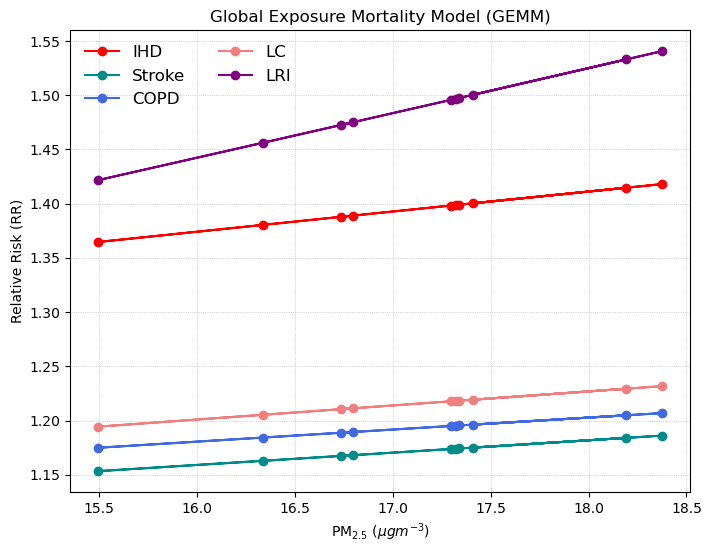

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Función para calcular el RR usando el modelo GEMM
def calculate_rr(Ci_values, beta, alpha, mu, nu, C0=2.4):
    delta_Ci = np.maximum(0, np.array(Ci_values) - C0)  # ∆Ci = max(0, Ci - C0)
    exposure_response = np.log(delta_Ci / alpha + 1) / (1 + np.exp(-(delta_Ci - mu) / nu))
    RR = np.exp(beta * exposure_response)  # Fórmula GEMM
    return RR

# Cargar los datos de PM2.5 desde un archivo Excel
data_file = "data_insumo/datos_PM25.xlsx"
pm_df = pd.read_excel(data_file, sheet_name="Hoja1")  # Ajusta el nombre de la hoja si es necesario
Ci_values = pm_df["PM2.5"].values  # Lista de concentraciones de PM2.5 para varios años

# Cargar los parámetros desde el archivo Excel
param_file = "data_insumo/parametros_enfermedad.xlsx"
params_df = pd.read_excel(param_file)

# Colores para diferenciar las enfermedades en la gráfica
colores = ['red','darkcyan','royalblue','lightcoral','purple']  

plt.figure(figsize=(8, 6))

# Iterar sobre cada enfermedad y calcular RR para cada concentración de PM2.5
for i, row in params_df.iterrows():
    enfermedad = row["enfermedad"]  # Nombre de la enfermedad desde el archivo
    beta, alpha, mu, nu = row["beta"], row["alpha"], row["mu"], row["nu"]
    RR_values = calculate_rr(Ci_values, beta, alpha, mu, nu)

    # Graficar con líneas conectando los puntos y la etiqueta con el nombre real de la enfermedad
    plt.plot(Ci_values, RR_values, marker="o", linestyle="-", color=colores[i % len(colores)], label=enfermedad)

# Personalización de la gráfica
plt.xlabel("PM$_{2.5}$ ($µg m^{-3}$)")
plt.ylabel("Relative Risk (RR)")
plt.title("Global Exposure Mortality Model (GEMM)")
plt.legend(ncol=2, frameon = False, fontsize = 12)
plt.grid(linestyle = ':', linewidth = 0.5)
plt.show()



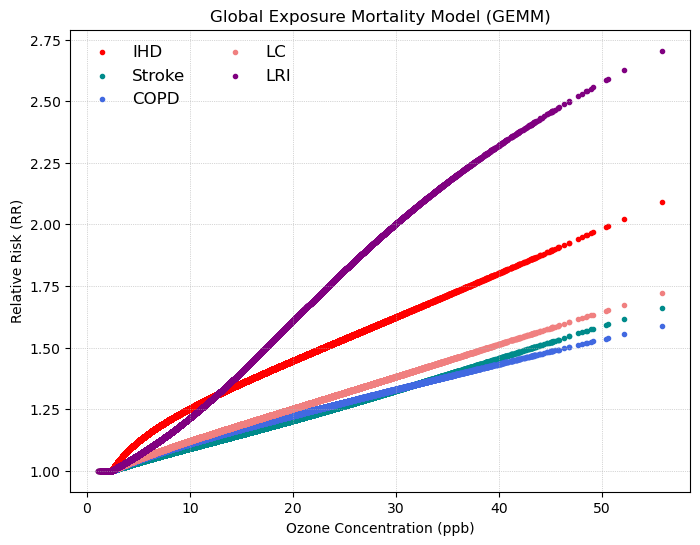

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Función para calcular el RR usando el modelo GEMM
def calculate_rr(Ci_values, beta, alpha, mu, nu, C0=2.4):
    delta_Ci = np.maximum(0, np.array(Ci_values) - C0)  # ∆Ci = max(0, Ci - C0)
    exposure_response = np.log(delta_Ci / alpha + 1) / (1 + np.exp(-(delta_Ci - mu) / nu))
    RR = np.exp(beta * exposure_response)  # Fórmula GEMM
    return RR

# Cargar los datos de PM2.5 desde un archivo Excel
    filename = "Ozono_llenado.csv"  # Reemplaza con el nombre de tu archivo
    df = pd.read_csv(filename)
#pm_df = pd.read_excel(df, sheet_name="Hoja1")  # Ajusta el nombre de la hoja si es necesario
Ci_values = df["Ozone"].values  # Lista de concentraciones de PM2.5 para varios años

# Cargar los parámetros desde el archivo Excel
param_file = "parametros_enfermedad.xlsx"
params_df = pd.read_excel(param_file)

# Colores para diferenciar las enfermedades en la gráfica
colores = ['red','darkcyan','royalblue','lightcoral','purple']

plt.figure(figsize=(8, 6))

# Iterar sobre cada enfermedad y calcular RR para cada concentración de PM2.5
for i, row in params_df.iterrows():
    enfermedad = row["enfermedad"]  # Nombre de la enfermedad desde el archivo
    beta, alpha, mu, nu = row["beta"], row["alpha"], row["mu"], row["nu"]
    RR_values = calculate_rr(Ci_values, beta, alpha, mu, nu)

    # Graficar con líneas conectando los puntos y la etiqueta con el nombre real de la enfermedad
    #plt.plot(Ci_values, RR_values, marker="o", linestyle="-", color=colores[i % len(colores)], label=enfermedad)
    plt.scatter(Ci_values, RR_values, marker= '.', color=colores[i % len(colores)], label=enfermedad)

#INTERVALO DE CONFIANZA DE CADA ENFERMEDAD

# Personalización de la gráfica
plt.xlabel("Ozone Concentration (ppb)")
plt.ylabel("Relative Risk (RR)")
plt.title("Global Exposure Mortality Model (GEMM)")
plt.legend(ncol=2, frameon = False, fontsize = 12)
plt.grid(linestyle = ':', linewidth = 0.5)
plt.show()

# REGRESION LINEAL


In [30]:
import pandas as pd

df = pd.read_excel("data_insumo/PM25_Localidad.xlsx")
display(df.head())

AÑO       LOCALIDAD  PM2.5  Total Población  Total Muertes
0  2022        Engativá  15.67           815262          61970
1  2022         Kennedy  33.59          1034293          55296
2  2022     Teusaquillo  14.51           167657          18005
3  2022  Ciudad Bolívar  19.22           656015          79002
4  2022        Fontibón  18.89           399020          22482

In [31]:
# Check for missing values in 'PM2.5', 'Total Población', and 'Total Muertes'
missing_values = df[['PM2.5', 'Total Población', 'Total Muertes']].isnull().sum()
print("Missing Values:\n", missing_values)

# Remove rows with missing values
df.dropna(subset=['PM2.5', 'Total Población', 'Total Muertes'], inplace=True)

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print("\nDuplicate Rows:", duplicate_rows)

# Remove duplicate rows
df.drop_duplicates(inplace=True)

Missing Values:
 PM2.5              1
Total Población    0
Total Muertes      0
dtype: int64

Duplicate Rows: 17


In [32]:
import numpy as np

# Function to identify outliers using IQR
def identify_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# Check for outliers in 'PM2.5', 'Total Población', and 'Total Muertes'
for column in ['PM2.5', 'Total Población', 'Total Muertes']:
    outliers = identify_outliers_iqr(df[column])
    print(f"\nOutliers in {column}:\n", outliers)

# Cap outliers in 'PM2.5', 'Total Población', and 'Total Muertes'
for column in ['PM2.5', 'Total Población', 'Total Muertes']:
    Q1 = np.percentile(df[column], 25)
    Q3 = np.percentile(df[column], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])


Outliers in PM2.5:
 1      33.590000
15     33.476841
43     36.404734
99     30.927954
113    31.950031
119    30.659083
127    30.259572
Name: PM2.5, dtype: float64

Outliers in Total Población:
 13     7873316
27     7823334
41     7732161
55     7592871
69     7412566
83     7337449
97     7300918
111    7273265
125    7252949
138    7228427
Name: Total Población, dtype: int64

Outliers in Total Muertes:
 13     522874
27     522874
41     429730
55     320224
69     310566
83     304563
97     297496
111    284285
125    276929
138    268807
Name: Total Muertes, dtype: int64


In [33]:
# Ensure the required columns are present
required_columns = ['AÑO', 'LOCALIDAD', 'PM2.5', 'Total Población', 'Total Muertes']
if not all(col in df.columns for col in required_columns):
    raise ValueError("Missing required columns in DataFrame")

# Convert data types to numeric
for col in ['PM2.5', 'Total Población', 'Total Muertes']:
    df[col] = pd.to_numeric(df[col])

# Drop any other columns
columns_to_drop = [col for col in df.columns if col not in required_columns]
df.drop(columns=columns_to_drop, inplace=True)

# Group the data by 'LOCALIDAD' and then by 'AÑO'
df_grouped = df.groupby(['LOCALIDAD', 'AÑO']).agg({
    'PM2.5': 'first',
    'Total Población': 'first',
    'Total Muertes': 'first'
}).reset_index()

display(df_grouped.head())

LOCALIDAD   AÑO      PM2.5  Total Población  Total Muertes
0    Bogotá  2013  17.295832        1515381.0        95816.5
1    Bogotá  2014  18.193595        1515381.0        95816.5
2    Bogotá  2015  17.407729        1515381.0        95816.5
3    Bogotá  2016  18.375612        1515381.0        95816.5
4    Bogotá  2017  17.338788        1515381.0        95816.5

In [34]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# Initialize a dictionary to store regression results
regression_results = {}

# Iterate over each unique location
for location in df_grouped['LOCALIDAD'].unique():
    # Filter data for the current location
    location_data = df_grouped[df_grouped['LOCALIDAD'] == location]

    # Prepare the feature matrix X and the target vector y
    X = location_data[['PM2.5', 'Total Población']]
    y = location_data['Total Muertes']

    # Create and fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Store the results
    regression_results[location] = {
        'intercept': model.intercept_,
        'coefficients': model.coef_,
        'r_squared': model.score(X, y)
    }

# Print the results
print(regression_results)

{'Bogotá': {'intercept': 95816.5, 'coefficients': array([0., 0.]), 'r_squared': 1.0}, 'Ciudad Bolívar': {'intercept': -398015.5551995363, 'coefficients': array([-281.33024228,    0.73349157]), 'r_squared': 0.9236967875599372}, 'Engativá': {'intercept': -663535.4150966988, 'coefficients': array([310.13520254,   0.87849872]), 'r_squared': 0.8521725948128241}, 'Fontibón': {'intercept': -79304.02817539524, 'coefficients': array([-4.12930393e+02,  2.72103865e-01]), 'r_squared': 0.9187726202480676}, 'Kennedy': {'intercept': -705874.9522388106, 'coefficients': array([3.46348311e+03, 6.30279637e-01]), 'r_squared': 0.7859690780085042}, 'Puente Aranda': {'intercept': -266244.03824317356, 'coefficients': array([188.93363628,   1.17608857]), 'r_squared': 0.9144259506509973}, 'San Cristóbal': {'intercept': -33593.09858179363, 'coefficients': array([-1.72827080e+02,  1.18348022e-01]), 'r_squared': 0.8554053595720466}, 'Suba': {'intercept': -287155.4087548194, 'coefficients': array([3.84400283e+02, 2

NameError: name 'sm' is not defined

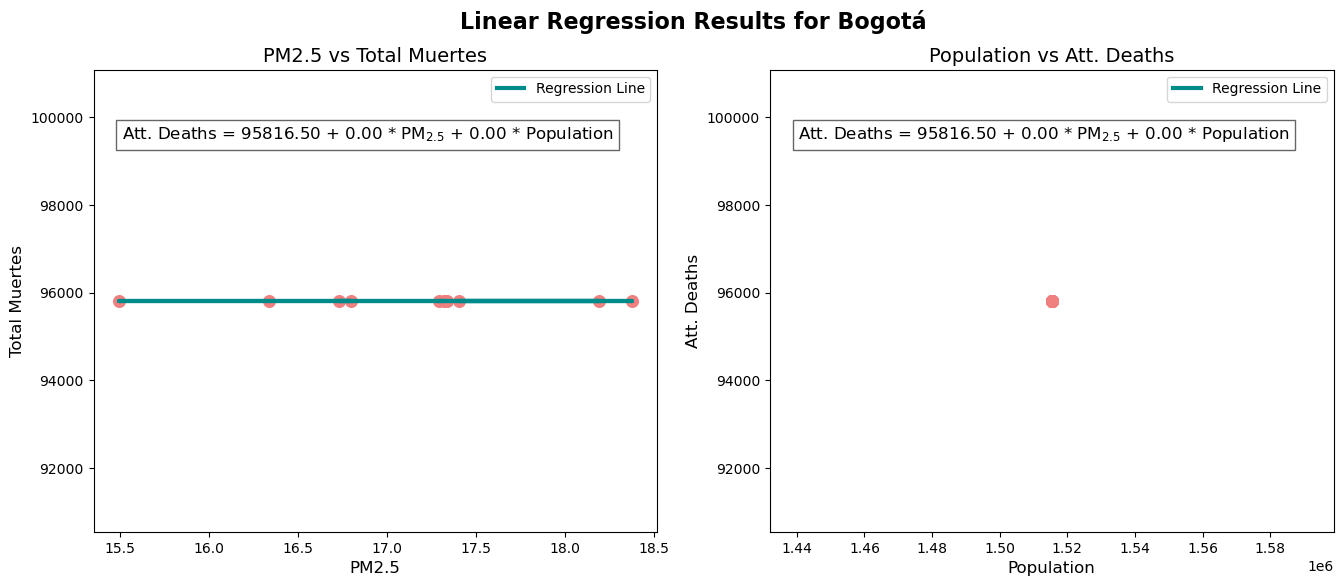

In [35]:
# Iterate through the regression results for each location
for location, results in regression_results.items():
    # Filter data for the current location
    location_data = df_grouped[df_grouped['LOCALIDAD'] == location]

    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Linear Regression Results for {location}', fontsize=16, fontweight='bold')

    # Extract coefficients and intercept
    intercept = results['intercept']
    coef_pm25 = results['coefficients'][0]
    coef_population = results['coefficients'][1]

    # **PM2.5 vs Total Muertes**
    axes[0].scatter(location_data['PM2.5'], location_data['Total Muertes'], color='lightcoral', s=70)
    axes[0].set_xlabel('PM2.5', fontsize=12)
    axes[0].set_ylabel('Total Muertes', fontsize=12)  # Keep "Total Muertes" in Spanish
    axes[0].set_title('PM2.5 vs Total Muertes', fontsize=14)

    # Calculate predicted Total Muertes based on PM2.5
    pm25_predictions = intercept + coef_pm25 * location_data['PM2.5'] + coef_population * location_data['Total Población'].mean()
    axes[0].plot(location_data['PM2.5'], pm25_predictions, color='darkcyan', label='Regression Line', linewidth=3)
    axes[0].legend()

    # Display the regression equation in the plot
    equation_pm25 = f'Att. Deaths = {intercept:.2f} + {coef_pm25:.2f} * PM$_{{2.5}}$ + {coef_population:.2f} * Population'
    axes[0].text(0.05, 0.85, equation_pm25, transform=axes[0].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

    # **Total Población vs Total Muertes**
    axes[1].scatter(location_data['Total Población'], location_data['Total Muertes'], color='lightcoral', s=70)
    axes[1].set_xlabel('Population', fontsize=12)  # Keep "Total Población" in Spanish
    axes[1].set_ylabel('Att. Deaths', fontsize=12)  # Keep "Total Muertes" in Spanish
    axes[1].set_title('Population vs Att. Deaths', fontsize=14)

    # Calculate predicted Total Muertes based on Total Población
    population_predictions = intercept + coef_pm25 * location_data['PM2.5'].mean() + coef_population * location_data['Total Población']
    axes[1].plot(location_data['Total Población'], population_predictions, color='darkcyan', label='Regression Line', linewidth=3)
    axes[1].legend()

    # Display the regression equation in the plot
    equation_population = f"Att. Deaths = {intercept:.2f} + {coef_pm25:.2f} * PM$_{{2.5}}$ + {coef_population:.2f} * Population"
    axes[1].text(0.05, 0.85, equation_population, transform=axes[1].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

    # **Calculate Regression Significance**
    X = location_data[['PM2.5', 'Total Población']]
    y = location_data['Total Muertes']
    X = sm.add_constant(X)  # Add constant for intercept

    model = sm.OLS(y, X).fit()
    p_values = model.pvalues
    r_squared = model.rsquared

    # Display significance results
    print(f"Regression Significance for {location}:")
    print(model.summary())  # Print full regression summary

    # Add R² value to the figure
    #r_squared_text = f'R² = {r_squared:.3f}'
    #axes[0].text(0.75, 0.1, r_squared_text, transform=axes[0].transAxes, fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.6))
    #axes[1].text(0.75, 0.1, r_squared_text, transform=axes[1].transAxes, fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.6))

    plt.tight_layout()
    plt.show()